<a href="https://colab.research.google.com/github/gomezphd/CAI2300C_NLP/blob/main/Project_4_NLP_for_Psychological_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MDC 2300C: Introduction to Natural Language Processing**

## **NLP for Psychological Text Classification: AI-Powered Mental Health Pattern Identification**

**Student**: Carlos C. Gomez
**Date**: March 2025
**Professor**: Dr. Ernesto Lee


---


This notebook performs NLP classification on psychological text data using:
1. A synthetic dataset (Part I)
2. A real mental health dataset (Part II)



---



# Introduction
This project implements Natural Language Processing (NLP) techniques to classify psychological text data. Mental health conditions often manifest in language patterns that can be computationally identified. Using supervised machine learning, we'll analyze both a synthetic dataset (with depression, anxiety, PTSD, and control categories) and a real-world mental health dataset to demonstrate how NLP can distinguish between different psychological states based on text alone.

# Environment Setup
The environment setup includes essential libraries for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), NLP processing (NLTK), and machine learning (scikit-learn). We also establish logging and standardize visualization settings for consistency. The OpenAI API integration offers potential for embedding-based text analysis, supplementing traditional NLP techniques.

In [32]:
# First, set up the environment
!pip install numpy pandas matplotlib seaborn scikit-learn nltk tqdm wordcloud openai --quiet

In [33]:
# Set OpenAI API key from Colab secrets
from google.colab import userdata
from openai import OpenAI

print("OpenAI API Configuration")
print("\n")

# Get API key from Colab secrets
api_key = userdata.get('OpenAI')  # Get API key from Colab secrets

# Configure OpenAI client
client = OpenAI(api_key=api_key)

# Test API connection with a simple embedding request
try:
    response = client.embeddings.create(
        model="text-embedding-3-small",
        input="Test connection to OpenAI API"
    )
    print("✅ OpenAI API connection successful!")

    # Get embedding dimension
    embedding_dimension = len(response.data[0].embedding)
    print(f"✅ Embedding dimension: {embedding_dimension}")

    # Set a flag to use embeddings in the notebook
    use_openai_embeddings = True

except Exception as e:
    print(f"❌ Error connecting to OpenAI API: {e}")
    print("Will proceed without OpenAI embeddings")
    use_openai_embeddings = False
    # Important clinical disclaimer

print("\n")
print("*" * 72)
print("IMPORTANT: This analysis is provided for educational purposes only.")
print("Clinical decision-making should rely on comprehensive assessment by qualified")
print("healthcare professionals following evidence-based practice guidelines.")
print("*" * 72)

OpenAI API Configuration




2025-03-13 22:19:23 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


✅ OpenAI API connection successful!
✅ Embedding dimension: 1536


************************************************************************
IMPORTANT: This analysis is provided for educational purposes only.
Clinical decision-making should rely on comprehensive assessment by qualified
healthcare professionals following evidence-based practice guidelines.
************************************************************************


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import datetime
import time
import logging
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud

# Libraries for model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc,
    precision_recall_curve
)
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack, csr_matrix

# Set up logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
    force=True
)

# Set up matplotlib
%matplotlib inline
plt.style.use('ggplot')

# Set random seed for reproducibility
np.random.seed(42)

# Download necessary NLTK resources
nltk_resources = ["punkt", "stopwords", "wordnet", "omw-1.4"]
for resource in nltk_resources:
    try:
        nltk.data.find(f"corpora/{resource}")
    except LookupError:
        nltk.download(resource, quiet=True)

In [35]:
# Utility functions

def print_section(title, char="="):
    """Log a formatted section title."""
    border = char * 80
    logging.info(f"\n{border}\n{title}\n{border}")

def load_dataset(url):
    """Load a dataset from a URL."""
    try:
        df = pd.read_csv(url)
        logging.info(f"✅ Dataset loaded successfully! {df.shape[0]:,} rows, {df.shape[1]} columns.")
        return df
    except Exception as e:
        logging.error(f"❌ Error loading dataset: {e}")
        return None

def generate_wordcloud(df, text_column, label_column, label, colormap='viridis'):
    """Generate and display a word cloud for a specific label."""
    text_data = ' '.join(df[df[label_column] == label][text_column])

    wordcloud = WordCloud(
        width=1000, height=500, background_color='white', colormap=colormap,
        max_words=150, contour_width=3
    ).generate(text_data)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{label} - Most Common Words', fontsize=18)
    plt.axis('off')
    plt.show()

def get_clinical_implications(category, sensitivity, specificity):
    """Return clinical implications based on the category and metrics."""
    try:
        if category == 'depression':
            if sensitivity < 0.7:
                return "Low sensitivity may miss cases requiring intervention"
            else:
                return "Good detection rate for a serious condition"
        elif category == 'anxiety':
            if sensitivity < 0.7:
                return "May miss anxiety cases that could benefit from treatment"
            else:
                return "Effective at identifying anxiety patterns"
        elif category == 'ptsd':
            if sensitivity < 0.7:
                return "Missing PTSD cases could have serious consequences"
            else:
                return "Good detection of trauma-related linguistic patterns"
        elif category == 'control':
            if specificity < 0.7:
                return "May incorrectly flag healthy expressions as concerning"
            else:
                return "Effectively identifies non-concerning expressions"
        elif category == 'Mental Health Concern':
            if sensitivity < 0.7:
                return "Model may miss individuals who need mental health support"
            else:
                return "Good at identifying text indicating mental health concerns"
        elif category == 'Non-Mental Health':
            if specificity < 0.7:
                return "May incorrectly label normal expressions as concerning"
            else:
                return "Effectively distinguishes non-concerning language patterns"
        else:
            logging.warning(f"⚠️ Unrecognized category: {category}")
            return "Clinical implications unclear for this category"
    except Exception as e:
        logging.error(f"❌ Error calculating clinical implications: {e}")
        return "Error in calculation"

def preprocess_text(text, preserve_psych_terms=True):
    """
    Preprocess text by cleaning, tokenizing, and lemmatizing.
    Uses a simple split method to avoid NLTK tokenization issues.

    Args:
        text (str): Text to preprocess
        preserve_psych_terms (bool): Whether to preserve psychological terms

    Returns:
        str: Preprocessed text
    """
    if not isinstance(text, str):
        return ""

    try:
        # Remove URLs and email addresses
        text = re.sub(r'https?://\S+|www\.\S+|\S+@\S+\.\S+', '', text)

        # Remove hashtags but keep the content
        text = re.sub(r'#(\w+)', r'\1', text)

        # Remove emojis and special characters
        text = re.sub(r'[^\w\s\-\'\.,:;!?]', ' ', text)

        # Convert to lowercase
        text = text.lower()

        # Handle contractions
        contractions = {
            "n't": " not", "'m": " am", "'re": " are", "'s": " is",
            "'ve": " have", "'ll": " will", "'d": " would"
        }
        for key, val in contractions.items():
            text = text.replace(key, val)

        # Remove standalone numbers but keep numbers within words
        text = re.sub(r'\b\d+\b', '', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # Get stopwords
        stop_words = set(stopwords.words('english'))

        if preserve_psych_terms:
            # Words to keep that might be relevant for psychological analysis
            psychological_terms = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves',
                            'never', 'always', 'feel', 'feeling', 'felt', 'alone', 'lonely',
                            'sad', 'angry', 'scared', 'afraid', 'anxious', 'worried', 'tired',
                            'exhausted', 'hopeless', 'helpless', 'worthless', 'guilty', 'ashamed',
                            'empty', 'numb', 'panic', 'stress', 'distress', 'fear', 'terror',
                            'happy', 'joy', 'glad', 'content', 'calm', 'peaceful', 'relaxed',
                            'cannot', "can't", "don't", "didn't", "couldn't", "wouldn't", "shouldn't"}

            # Remove psychological terms from stopwords
            stop_words = stop_words - psychological_terms

        # Use simple split instead of nltk.word_tokenize to avoid the punkt_tab error
        tokens = text.split()

        # Remove stopwords and lemmatize
        lemmatizer = WordNetLemmatizer()
        filtered_tokens = []

        for token in tokens:
            if token not in stop_words:
                # If preserving psych terms, don't lemmatize them
                if preserve_psych_terms and token in psychological_terms:
                    filtered_tokens.append(token)
                else:
                    filtered_tokens.append(lemmatizer.lemmatize(token))

        # Join tokens back into text
        processed_text = ' '.join(filtered_tokens)

        return processed_text
    except Exception as e:
        logging.error(f"❌ Error in text preprocessing: {e}")
        return ""

def generate_wordcloud(df, text_column, label_column, label, colormap='viridis'):
    """
    Generate and display a word cloud for a specific label.
    Handles empty text data gracefully.
    """
    # Join all text for the given category
    text_data = ' '.join(df[df[label_column] == label][text_column]).strip()

    # Check if there's any text to visualize
    if not text_data:
        logging.warning(f"⚠️ No text data available for category '{label}'. Cannot generate word cloud.")
        return

    # Generate word cloud
    try:
        wordcloud = WordCloud(
            width=1000, height=500, background_color='white', colormap=colormap,
            max_words=150, contour_width=3
        ).generate(text_data)

        # Display word cloud
        plt.figure(figsize=(12, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'{label} - Most Common Words', fontsize=18)
        plt.axis('off')
        plt.show()
    except Exception as e:
        logging.error(f"❌ Error generating word cloud for '{label}': {e}")


# Part I: Synthetic Dataset Analysis



In [36]:
print_section("PART I: SYNTHETIC DATASET ANALYSIS")
logging.info("🔹 Starting analysis with real mental health dataset...")

2025-03-13 22:19:23 - INFO - 
PART I: SYNTHETIC DATASET ANALYSIS
2025-03-13 22:19:23 - INFO - 🔹 Starting analysis with real mental health dataset...


## 1. Dataset Creation and Exploration
This section creates a synthetic mental health dataset with text samples representing four psychological categories: depression, anxiety, PTSD, and control (non-clinical). The synthetic nature allows us to clearly define language patterns associated with each condition. We analyze the distribution of categories, add realistic timestamps, severity scores, and engagement metrics to simulate real-world data characteristics.

In [37]:
# PART I: SYNTHETIC DATASET ANALYSIS

print_section("PART I: SYNTHETIC DATASET ANALYSIS")
logging.info("🔹 Starting analysis with synthetic dataset...")

# 1. Dataset Creation
print_section("1. Dataset Creation and Exploration")
logging.info("🔹 Creating synthetic mental health dataset...")

# Create synthetic dataset
synthetic_df = {
    'text': [
        # Depression expressions - 20 examples
        "I feel so tired all the time and nothing seems to bring me joy anymore... :(",
        "It's been weeks since I've felt motivated to do anything at all. #strugglinghard",
        "I don't see any point in trying anymore, nothing ever changes. www.sadness.com",
        "Haven't been able to sleep properly in days, just feeling empty. *sigh*",
        "I'm starting to think everyone would be better off without me. 100% serious.",
        "I've been in bed for three days, can't find the energy to get up!!!!!",
        "I feel like I'm drowning in darkness with no way out. #mentalhealth",
        "Nothing matters anymore, I just feel numb to everything...FML",
        "I'm a complete failure and I'll never amount to anything worthwhile. (Not joking)",
        "I've lost interest in everything I used to enjoy. EMAIL ME: user@example.com",
        "Every day feels exactly the same - just a blur of emptiness and fatigue.",
        "I keep wondering if life will ever feel worth living again. So exhausted.",
        "My appetite has completely disappeared, lost 10 pounds without trying.",
        "Can't remember the last time I genuinely smiled or laughed. #depression",
        "The simplest tasks feel overwhelming - even showering takes all my energy.",
        "I'm just going through the motions, pretending to be okay when I'm falling apart.",
        "Sleep is my only escape from feeling this way, but I either can't sleep or sleep too much.",
        "I feel like I'm watching my life through a gray filter that dulls everything.",
        "The future looks completely hopeless from where I'm standing right now.",
        "I used to care about so many things, now I can barely care about myself.",

        # Anxiety expressions - 15 examples
        "I can't stop worrying about everything that could go wrong tomorrow. EVERYTHING!!!!",
        "My heart races every time I have to speak in front of people. 120BPM minimum.",
        "Constantly on edge waiting for something bad to happen. #anxiety #stressed",
        "Panic attacks are becoming more frequent, even when I'm just grocery shopping. 😰",
        "Can't concentrate at work because I'm constantly thinking about all my mistakes. 23 mistakes today.",
        "My mind won't stop racing with worst-case scenarios when I try to sleep.",
        "I rehearse conversations in my head over and over before making a simple phone call.",
        "The thought of social gatherings makes my chest tight and my palms sweat profusely.",
        "I check my email every 5 minutes when waiting for an important response. Can't focus!",
        "Always imagining catastrophic outcomes for minor symptoms. WebMD is my nightmare.",
        "I've started avoiding elevators because I'm terrified of being trapped. Stairs only!",
        "The constant feeling that I've forgotten something important is exhausting me.",
        "My thoughts spiral out of control at 3am about things I can't even control. #insomnia",
        "I triple-check everything - doors, stove, emails - before I can leave the house.",
        "Physical symptoms (dizziness, nausea, trembling) appear whenever I feel stressed.",

        # PTSD expressions - 15 examples
        "The sound of fireworks sends me into a panic, bringing me back to the war. 07/04/2022 was TERRIBLE",
        "I've been having nightmares about the accident almost every night. 17 nights in a row now.",
        "I avoid driving on highways since the crash, even if it means taking a much longer route. +45min commute.",
        "I'm constantly scanning my surroundings for potential threats. ALWAYS vigilant!!! #hyperalert",
        "Certain smells immediately trigger vivid memories of the traumatic event. Can't handle gasoline smell anymore!!",
        "I feel detached from everyone around me since the incident, like I'm watching life through glass.",
        "Unexpected loud noises make me drop to the ground instinctively. Embarrassing in public.",
        "The anniversary of the event is approaching and I'm already having more flashbacks.",
        "I can't watch certain movie scenes that remind me of what happened. Had to leave the theater.",
        "Sometimes I feel like I'm right back there, seeing and feeling everything all over again.",
        "I've mapped out all the exits in every building I regularly visit. Need escape routes.",
        "My relationships are suffering because I can't explain why I react the way I do.",
        "I avoid certain streets/locations that remind me of what happened. Taking detours everywhere.",
        "The guilt of surviving when others didn't haunts me constantly. Why me?",
        "I startle so easily now that people have stopped trying to approach me from behind.",

        # Control expressions (non-clinical) - 15 examples
        "Just had a great weekend with friends, feeling recharged for the week! 😊 www.happylife.com",
        "Planning my vacation next month, so excited to explore new places. #wanderlust #travel #vacation2023",
        "Finished my project early and got great feedback from my boss. SUCCESS: 100%!!!",
        "Had a productive day organizing my home office, feels good to accomplish something. #adulting",
        "Just adopted a puppy and it's bringing so much joy to my daily routine. Contact: dogtrainer@email.com",
        "Tried a new recipe tonight and it turned out delicious! Will definitely make it again.",
        "Morning workout complete - starting the day with endorphins is the best feeling!",
        "Just finished that book I've been reading. The ending was unexpected but satisfying.",
        "Family game night was hilarious, haven't laughed that hard in ages! #familytime",
        "Finally mastered that difficult piano piece I've been practicing for weeks. Practice pays off!",
        "The weather is perfect today - taking advantage with a hike in the mountains.",
        "My garden is thriving this year - the tomatoes are especially impressive!",
        "Reconnected with an old friend today. Amazing how we picked up right where we left off.",
        "Volunteering at the animal shelter was rewarding. Might become a regular thing!",
        "Just submitted my application for that dream job. Fingers crossed but feeling confident!"
    ],
    'label': ['depression'] * 20 + ['anxiety'] * 15 + ['ptsd'] * 15 + ['control'] * 15
}

# Create DataFrame
df_synthetic = pd.DataFrame(synthetic_df)
logging.info(f"✅ Synthetic dataset created with {len(df_synthetic)} entries.")

# Add random NULL values for data cleaning testing
random.seed(42)
null_indices = random.sample(range(len(df_synthetic)), 5)
for idx in null_indices:
    if random.random() < 0.5:
        df_synthetic.at[idx, 'text'] = np.nan
    else:
        df_synthetic.at[idx, 'label'] = np.nan
logging.info(f"✅ Introduced {len(null_indices)} random NULL values for data cleaning tests.")

# Display dataset statistics
logging.info(f"Total entries: {len(df_synthetic)}")
logging.info(f"Categories: {', '.join(df_synthetic['label'].dropna().unique())}")
logging.info(f"Missing values: {df_synthetic.isnull().sum().sum()}")

# Add timestamps to simulate real data
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2024, 1, 1)
date_range = (end_date - start_date).days
df_synthetic['timestamp'] = [start_date + datetime.timedelta(days=np.random.randint(0, date_range)) for _ in range(len(df_synthetic))]
df_synthetic['timestamp'] = pd.to_datetime(df_synthetic['timestamp'])
df_synthetic = df_synthetic.sort_values('timestamp').reset_index(drop=True)
logging.info("✅ Assigned realistic timestamps to dataset.")

# Add severity scores (1-10) for clinical categories
def assign_severity_score(row):
    if row['label'] in ['depression', 'anxiety', 'ptsd']:
        # Higher severity for posts with concerning keywords
        text = str(row['text']).lower() if not pd.isna(row['text']) else ""
        concerning_words = ['serious', 'terrible', 'exhausted', 'hopeless', 'panic', 'nightmare', 'trauma']

        # Base score
        score = random.randint(4, 8)

        # Increase score for concerning content
        for word in concerning_words:
            if word in text:
                score = min(10, score + 1)

        return score
    else:
        # Control posts get low severity
        return random.randint(1, 3)

df_synthetic['severity_score'] = df_synthetic.apply(assign_severity_score, axis=1)
logging.info("✅ Added clinical severity scores to dataset.")

# Add user engagement metrics
df_synthetic['views'] = [random.randint(10, 500) for _ in range(len(df_synthetic))]
df_synthetic['interactions'] = [random.randint(0, 50) for _ in range(len(df_synthetic))]
df_synthetic['flagged_by_users'] = [random.choices([0, 1], weights=[0.9, 0.1])[0] for _ in range(len(df_synthetic))]

# Add content length metrics
df_synthetic['char_count'] = df_synthetic['text'].str.len().fillna(0).astype(int)
df_synthetic['word_count'] = df_synthetic['text'].str.split().str.len().fillna(0).astype(int)


2025-03-13 22:19:23 - INFO - 
PART I: SYNTHETIC DATASET ANALYSIS
2025-03-13 22:19:23 - INFO - 🔹 Starting analysis with synthetic dataset...
2025-03-13 22:19:23 - INFO - 
1. Dataset Creation and Exploration
2025-03-13 22:19:23 - INFO - 🔹 Creating synthetic mental health dataset...
2025-03-13 22:19:23 - INFO - ✅ Synthetic dataset created with 65 entries.
2025-03-13 22:19:23 - INFO - ✅ Introduced 5 random NULL values for data cleaning tests.
2025-03-13 22:19:23 - INFO - Total entries: 65
2025-03-13 22:19:23 - INFO - Categories: depression, anxiety, ptsd, control
2025-03-13 22:19:23 - INFO - Missing values: 5
2025-03-13 22:19:23 - INFO - ✅ Assigned realistic timestamps to dataset.
2025-03-13 22:19:23 - INFO - ✅ Added clinical severity scores to dataset.


2025-03-13 22:19:23 - INFO - 🔹 Visualizing label distribution...
<ipython-input-38-7aa1968c5f50>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_synthetic['label'], palette='viridis')


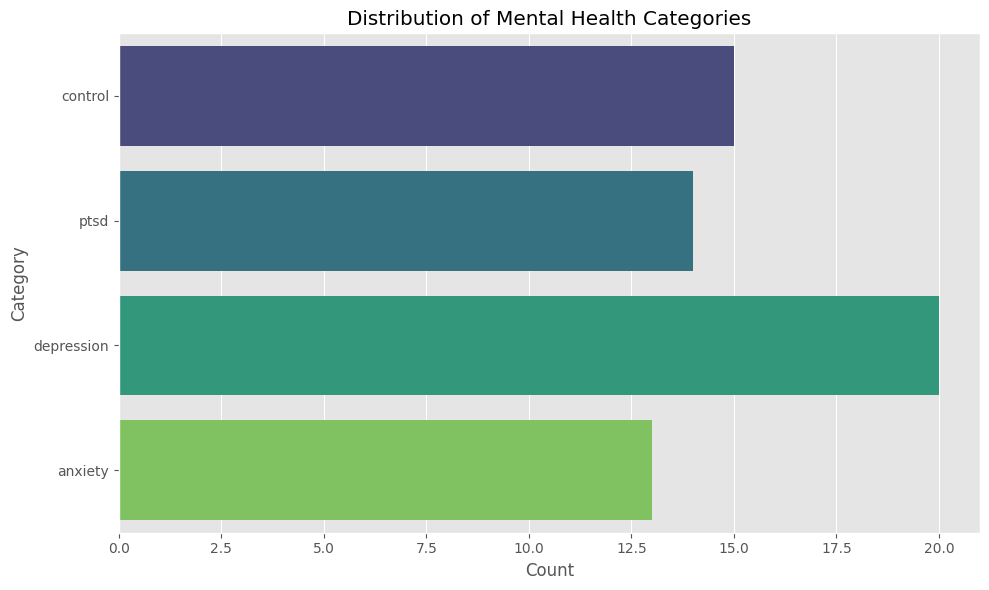

2025-03-13 22:19:24 - INFO - 🔹 Visualizing monthly posting trends...


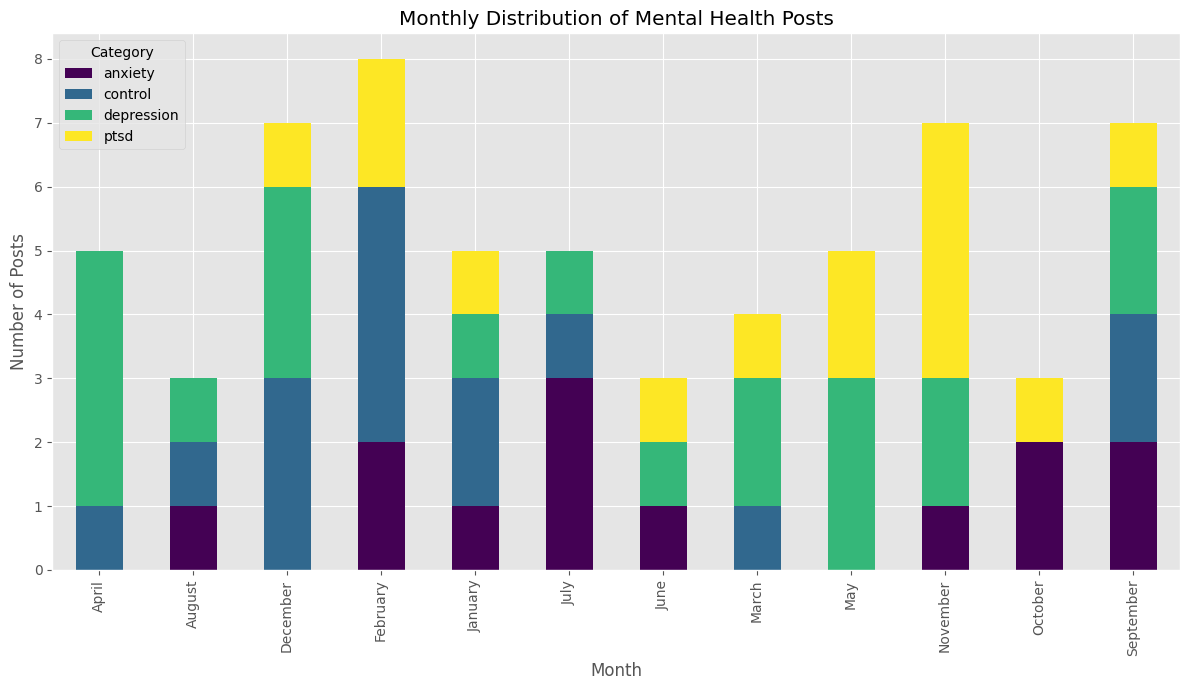

2025-03-13 22:19:25 - INFO - 🔹 Visualizing severity score distribution...
<ipython-input-38-7aa1968c5f50>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='severity_score', data=df_synthetic, palette='viridis')


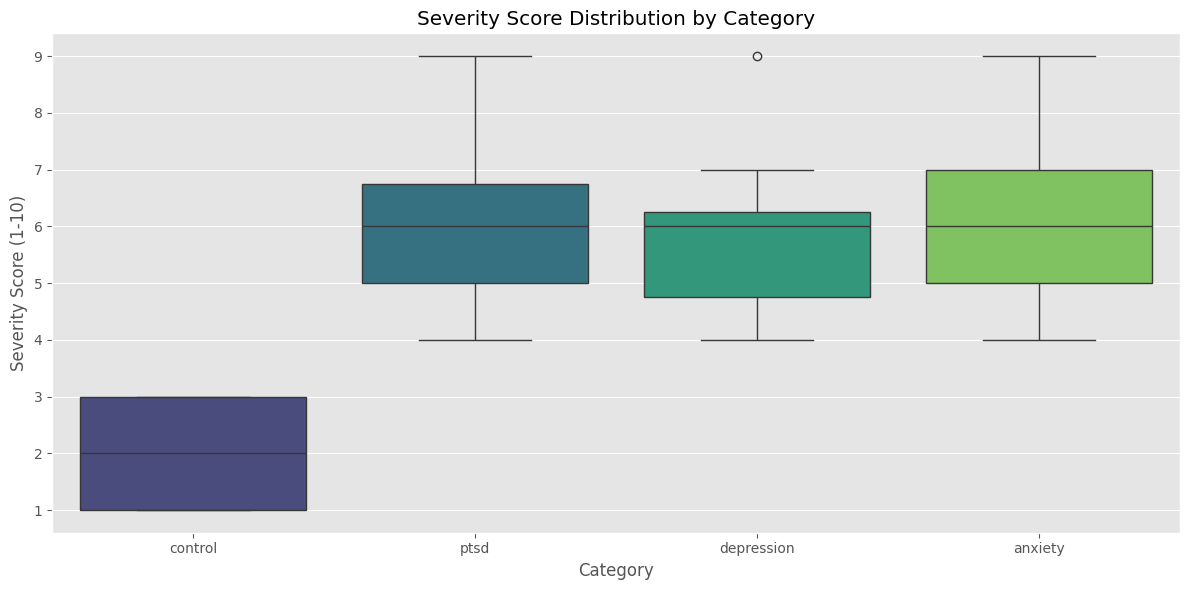

In [38]:
# 1.1 Data Exploration

# Display label distribution
logging.info("🔹 Visualizing label distribution...")
plt.figure(figsize=(10, 6))
sns.countplot(y=df_synthetic['label'], palette='viridis')
plt.title('Distribution of Mental Health Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

# Monthly post distribution
logging.info("🔹 Visualizing monthly posting trends...")
df_synthetic['month'] = df_synthetic['timestamp'].dt.month_name()
monthly_counts = df_synthetic.groupby(['month', 'label']).size().unstack().fillna(0)
monthly_counts.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 7))
plt.title('Monthly Distribution of Mental Health Posts')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.legend(title='Category')
plt.tight_layout()
plt.show()

# Severity score distribution
logging.info("🔹 Visualizing severity score distribution...")
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='severity_score', data=df_synthetic, palette='viridis')
plt.title('Severity Score Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Severity Score (1-10)')
plt.tight_layout()
plt.show()


## 2. Data Cleaning and Preprocessing
Effective NLP requires thorough text preprocessing. Our approach includes:
- Removing URLs, email addresses, and special characters
- Converting text to lowercase
- Handling contractions
- Removing standalone numbers
- Removing stopwords (while preserving psychologically relevant terms)
- Lemmatization to reduce words to their base form

Preserving psychological terms is critical - words like "sad," "anxious," or "afraid" might typically be removed as stopwords, but they're essential for mental health classification.

2025-03-13 22:19:25 - INFO - 
2. Data Cleaning and Preprocessing
2025-03-13 22:19:25 - INFO - 🔹 Starting text preprocessing for synthetic dataset...
2025-03-13 22:19:25 - INFO - ✅ Created cleaned dataset with 60 entries (removed 5 rows with NULL values).


Preprocessing Synthetic Text:   0%|          | 0/60 [00:00<?, ?it/s]

2025-03-13 22:19:25 - INFO - 
🔹 Sample of original vs processed text:
2025-03-13 22:19:25 - INFO - Original: Volunteering at the animal shelter was rewarding. Might become a regular thing!
2025-03-13 22:19:25 - INFO - Processed: volunteering animal shelter rewarding. might become regular thing!
2025-03-13 22:19:25 - INFO - 
2025-03-13 22:19:25 - INFO - Original: Just had a great weekend with friends, feeling recharged for the week! 😊 www.happylife.com
2025-03-13 22:19:25 - INFO - Processed: great weekend friends, feeling recharged week!
2025-03-13 22:19:25 - INFO - 
2025-03-13 22:19:25 - INFO - Original: Sometimes I feel like I'm right back there, seeing and feeling everything all over again.
2025-03-13 22:19:25 - INFO - Processed: sometimes i feel like i right back there, seeing feeling everything again.
2025-03-13 22:19:25 - INFO - 
<ipython-input-39-db0d4f746a0e>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `

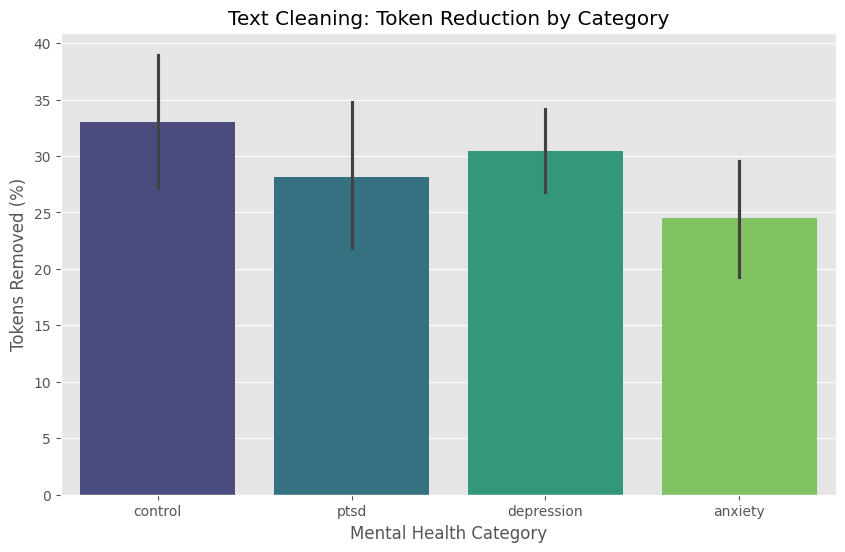

2025-03-13 22:19:26 - INFO - 🔹 Generating word clouds for each category...


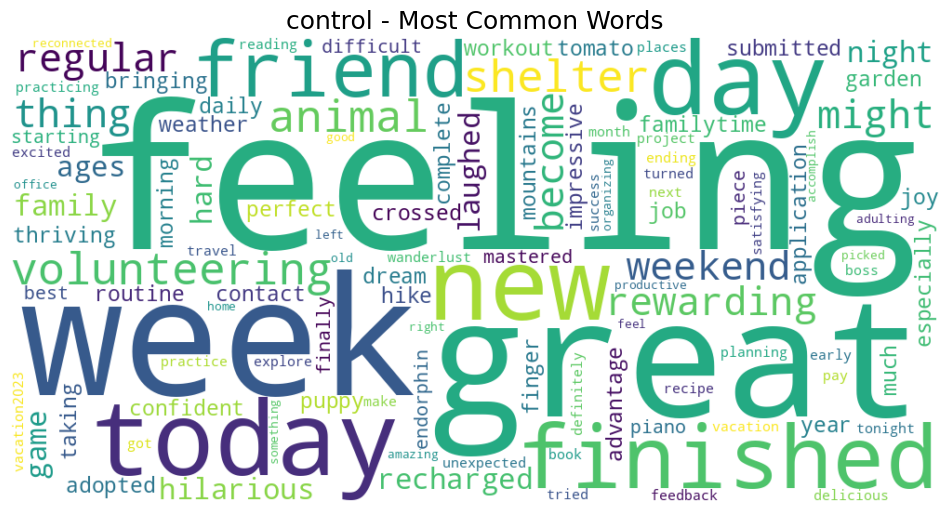

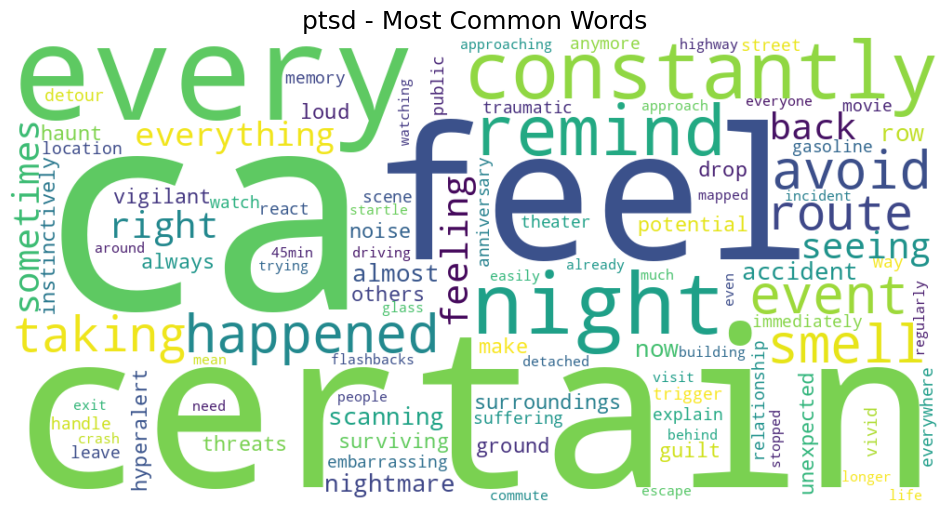

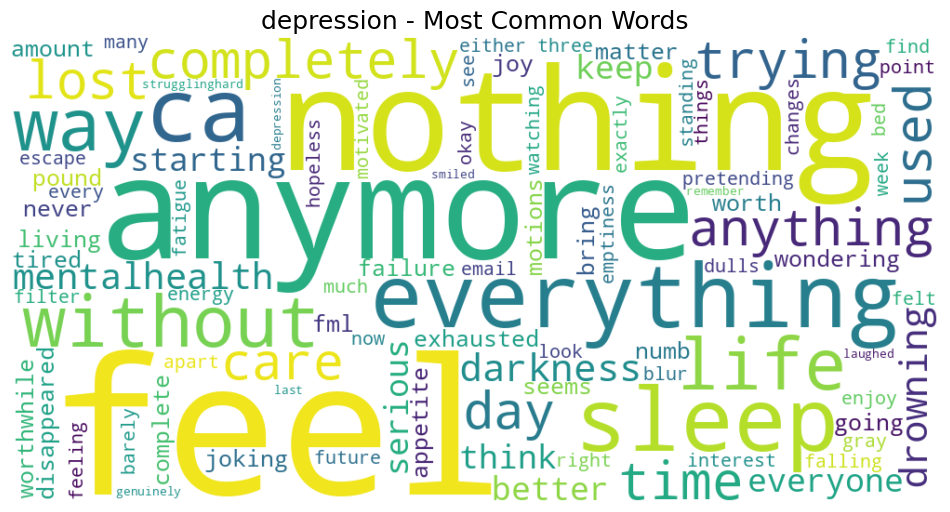

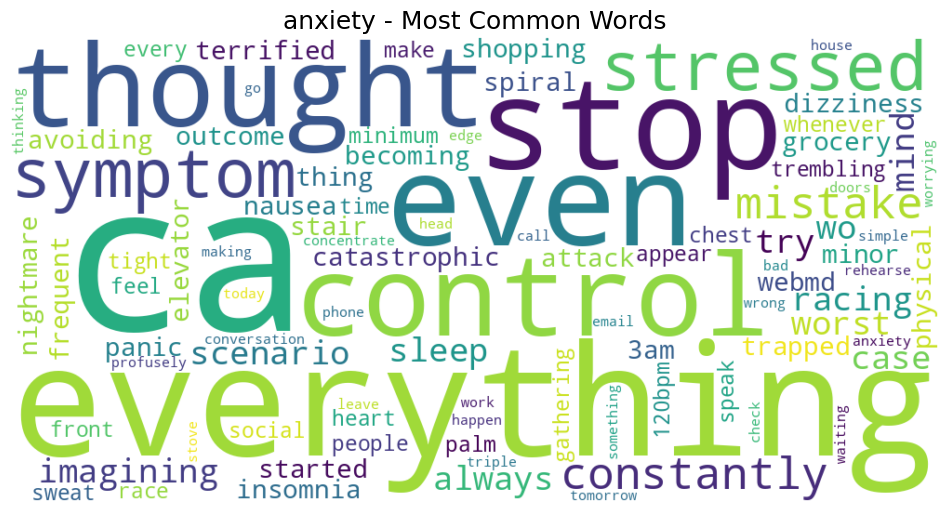

In [39]:
# 2. Data Cleaning and Preprocessing
print_section("2. Data Cleaning and Preprocessing")
logging.info("🔹 Starting text preprocessing for synthetic dataset...")

# Create cleaned dataset by removing NULLs
df_synthetic_clean = df_synthetic.dropna(subset=['text', 'label']).reset_index(drop=True)
logging.info(f"✅ Created cleaned dataset with {len(df_synthetic_clean)} entries (removed {len(df_synthetic) - len(df_synthetic_clean)} rows with NULL values).")

# Apply preprocessing function to clean text
tqdm.pandas(desc="Preprocessing Synthetic Text")
df_synthetic_clean['processed_text'] = df_synthetic_clean['text'].progress_apply(preprocess_text)

# Display sample of processed text
sample_processed = df_synthetic_clean[['text', 'processed_text']].head(3)
logging.info("\n🔹 Sample of original vs processed text:")
for i, row in sample_processed.iterrows():
    logging.info(f"Original: {row['text']}")
    logging.info(f"Processed: {row['processed_text']}")
    logging.info("")

# Calculate token reduction
df_synthetic_clean['original_token_count'] = df_synthetic_clean['text'].apply(lambda x: len(str(x).split()))
df_synthetic_clean['processed_token_count'] = df_synthetic_clean['processed_text'].apply(lambda x: len(x.split()))
df_synthetic_clean['token_reduction'] = df_synthetic_clean['original_token_count'] - df_synthetic_clean['processed_token_count']
df_synthetic_clean['token_reduction_percent'] = (df_synthetic_clean['token_reduction'] / df_synthetic_clean['original_token_count'] * 100).round(1)

# Visualize token reduction
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='token_reduction_percent', data=df_synthetic_clean, palette='viridis')
plt.title('Text Cleaning: Token Reduction by Category')
plt.xlabel('Mental Health Category')
plt.ylabel('Tokens Removed (%)')
plt.show()

# Generate word clouds for each category
logging.info("🔹 Generating word clouds for each category...")
for category in df_synthetic_clean['label'].unique():
    generate_wordcloud(df_synthetic_clean, 'processed_text', 'label', category)


## 3. Train/Test Split
We implement stratified sampling to maintain the class distribution across training and testing sets. This ensures that both sets contain representative samples of each mental health category, which is crucial for reliable model evaluation, especially with imbalanced classes.

2025-03-13 22:19:36 - INFO - 
3. Train/Test Split (Synthetic Dataset)
2025-03-13 22:19:36 - INFO - 🔹 Splitting synthetic data into training and testing sets...
2025-03-13 22:19:36 - INFO - ✅ Training set size: 48
2025-03-13 22:19:36 - INFO - ✅ Testing set size: 12
2025-03-13 22:19:36 - INFO - 
🔹 Training set class distribution:
2025-03-13 22:19:36 - INFO -   depression: 29.2%
2025-03-13 22:19:36 - INFO -   control: 25.0%
2025-03-13 22:19:36 - INFO -   ptsd: 22.9%
2025-03-13 22:19:36 - INFO -   anxiety: 22.9%
2025-03-13 22:19:36 - INFO - 
🔹 Testing set class distribution:
2025-03-13 22:19:36 - INFO -   depression: 33.3%
2025-03-13 22:19:36 - INFO -   control: 25.0%
2025-03-13 22:19:36 - INFO -   ptsd: 25.0%
2025-03-13 22:19:36 - INFO -   anxiety: 16.7%


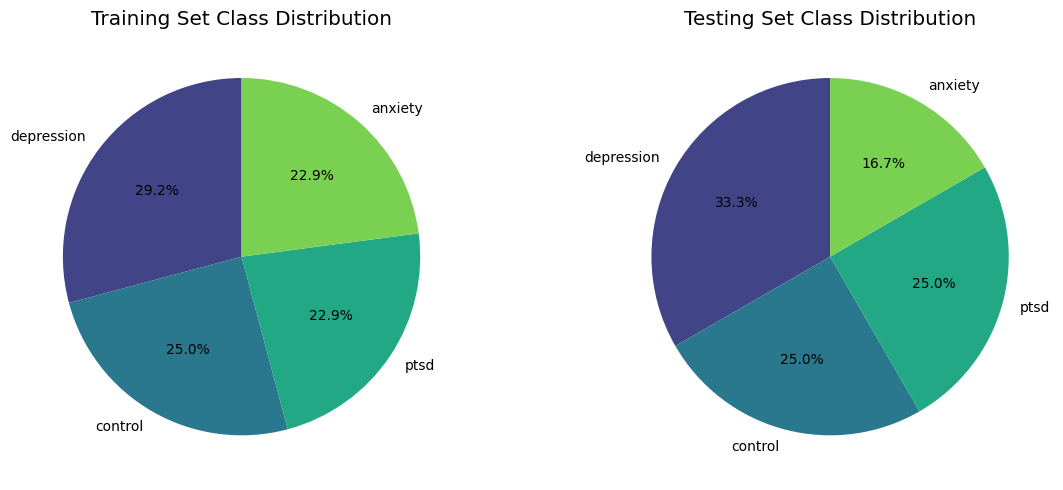

In [40]:

# 3. Train/Test Split
print_section("3. Train/Test Split (Synthetic Dataset)")
logging.info("🔹 Splitting synthetic data into training and testing sets...")

# Split data
X_synth = df_synthetic_clean['processed_text']
y_synth = df_synthetic_clean['label']

# Use stratified sampling to maintain class distribution
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(
    X_synth, y_synth, test_size=0.2, random_state=42, stratify=y_synth
)

logging.info(f"✅ Training set size: {X_train_synth.shape[0]}")
logging.info(f"✅ Testing set size: {X_test_synth.shape[0]}")

# Check class distribution in training and testing sets
train_dist = y_train_synth.value_counts(normalize=True).mul(100).round(1)
test_dist = y_test_synth.value_counts(normalize=True).mul(100).round(1)

logging.info("\n🔹 Training set class distribution:")
for label, percentage in train_dist.items():
    logging.info(f"  {label}: {percentage}%")

logging.info("\n🔹 Testing set class distribution:")
for label, percentage in test_dist.items():
    logging.info(f"  {label}: {percentage}%")

# Visualize class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(y_train_synth.value_counts(), labels=y_train_synth.value_counts().index, autopct='%1.1f%%',
        colors=sns.color_palette("viridis", len(y_train_synth.unique())), startangle=90)
plt.title('Training Set Class Distribution')

plt.subplot(1, 2, 2)
plt.pie(y_test_synth.value_counts(), labels=y_test_synth.value_counts().index, autopct='%1.1f%%',
        colors=sns.color_palette("viridis", len(y_test_synth.unique())), startangle=90)
plt.title('Testing Set Class Distribution')

plt.tight_layout()
plt.show()

## 4. Text Vectorization and Model Development
Text must be converted to numerical format for machine learning algorithms. We use TF-IDF (Term Frequency-Inverse Document Frequency) vectorization, which weights terms based on their importance to a document relative to the entire corpus. This approach prioritizes distinctive terms in each mental health category over commonly used words.

We train two complementary models:
- Logistic Regression: Effective for text classification with interpretable coefficients
- Random Forest: Ensemble approach that can capture non-linear relationships in the text data

In [41]:
# 4. Text Vectorization and Model Development
print_section("4. Text Vectorization and Model Development (Synthetic Dataset)")
logging.info("🔹 Creating TF-IDF vectors and training models...")

# Create TF-IDF vectors
tfidf_vectorizer_synth = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    ngram_range=(1, 2),
    use_idf=True,
    sublinear_tf=True
)

# Transform training data
X_train_tfidf_synth = tfidf_vectorizer_synth.fit_transform(X_train_synth)
X_test_tfidf_synth = tfidf_vectorizer_synth.transform(X_test_synth)

logging.info(f"✅ TF-IDF vectorization complete. Feature matrix shape: {X_train_tfidf_synth.shape}")

# Train Logistic Regression model
logging.info("🔹 Training Logistic Regression model...")
lr_model_synth = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs',
    C=1.0,
    random_state=42
)

start_time = time.time()
lr_model_synth.fit(X_train_tfidf_synth, y_train_synth)
lr_training_time = time.time() - start_time
logging.info(f"✅ Logistic Regression model trained in {lr_training_time:.2f} seconds")

# Train Random Forest model
logging.info("🔹 Training Random Forest model...")
rf_model_synth = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

start_time = time.time()
rf_model_synth.fit(X_train_tfidf_synth, y_train_synth)
rf_training_time = time.time() - start_time
logging.info(f"✅ Random Forest model trained in {rf_training_time:.2f} seconds")


2025-03-13 22:19:36 - INFO - 
4. Text Vectorization and Model Development (Synthetic Dataset)
2025-03-13 22:19:36 - INFO - 🔹 Creating TF-IDF vectors and training models...
2025-03-13 22:19:36 - INFO - ✅ TF-IDF vectorization complete. Feature matrix shape: (48, 46)
2025-03-13 22:19:36 - INFO - 🔹 Training Logistic Regression model...
2025-03-13 22:19:36 - INFO - ✅ Logistic Regression model trained in 0.01 seconds
2025-03-13 22:19:36 - INFO - 🔹 Training Random Forest model...
2025-03-13 22:19:37 - INFO - ✅ Random Forest model trained in 0.26 seconds


## 5. Model Evaluation
Model evaluation uses multiple metrics to gain a comprehensive understanding of performance:
- Accuracy: Overall correctness of classifications
- Precision & Recall: Balance between false positives and false negatives
- F1-Score: Harmonic mean of precision and recall
- Confusion Matrices: Detailed breakdown of predictions by class
- ROC Curves: Model performance across different classification thresholds

For mental health applications, we particularly focus on sensitivity (recall) as missing cases of concern (false negatives) could have serious clinical implications.

2025-03-13 22:19:37 - INFO - 
5. Model Evaluation (Synthetic Dataset)
2025-03-13 22:19:37 - INFO - 🔹 Evaluating model performance...
2025-03-13 22:19:37 - INFO - 
🔹 Logistic Regression (Synthetic) Results:
2025-03-13 22:19:37 - INFO - Accuracy: 0.4167
2025-03-13 22:19:37 - INFO - Classification Report:
              precision    recall  f1-score   support

     anxiety       0.00      0.00      0.00         2
     control       0.67      0.67      0.67         3
  depression       0.50      0.25      0.33         4
        ptsd       0.40      0.67      0.50         3

    accuracy                           0.42        12
   macro avg       0.39      0.40      0.38        12
weighted avg       0.43      0.42      0.40        12



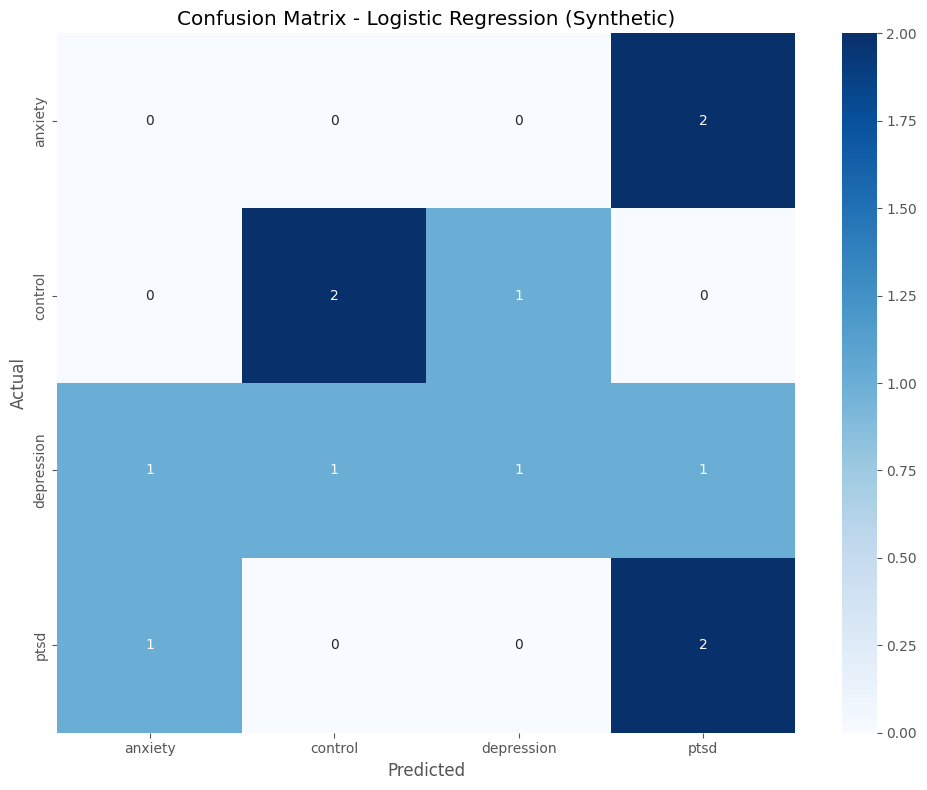

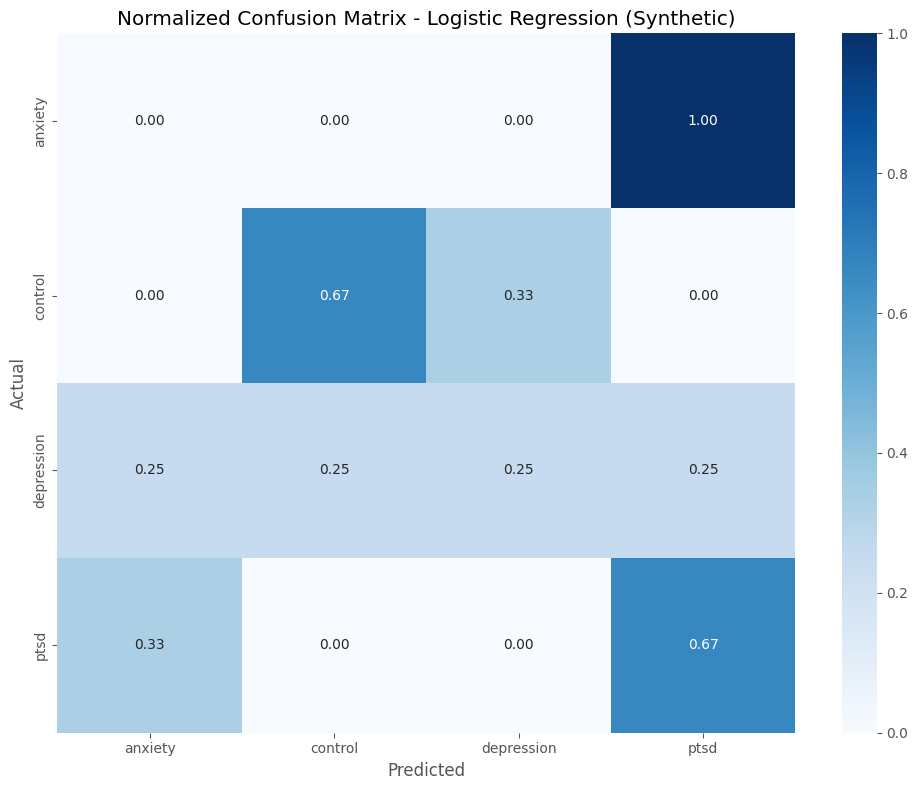

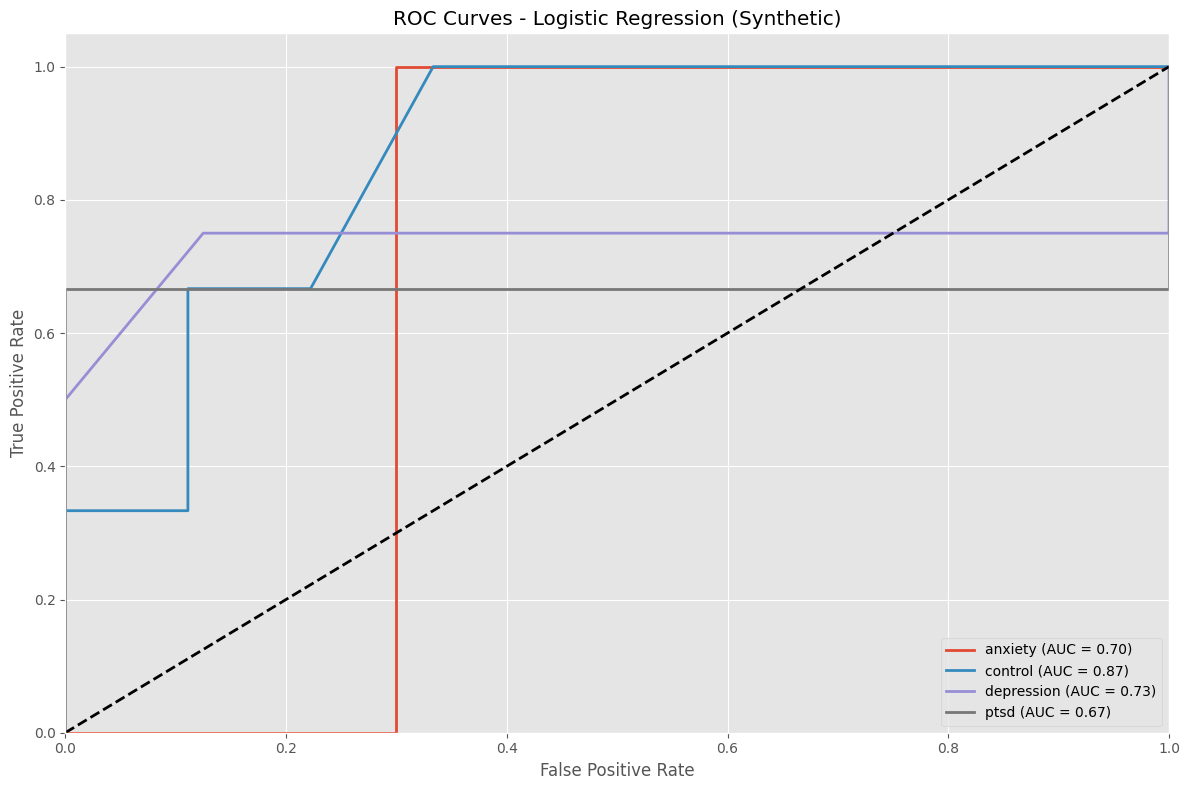

2025-03-13 22:19:39 - INFO - 
🔹 Random Forest (Synthetic) Results:
2025-03-13 22:19:39 - INFO - Accuracy: 0.5833
2025-03-13 22:19:39 - INFO - Classification Report:
              precision    recall  f1-score   support

     anxiety       0.50      0.50      0.50         2
     control       0.50      1.00      0.67         3
  depression       1.00      0.25      0.40         4
        ptsd       0.67      0.67      0.67         3

    accuracy                           0.58        12
   macro avg       0.67      0.60      0.56        12
weighted avg       0.71      0.58      0.55        12



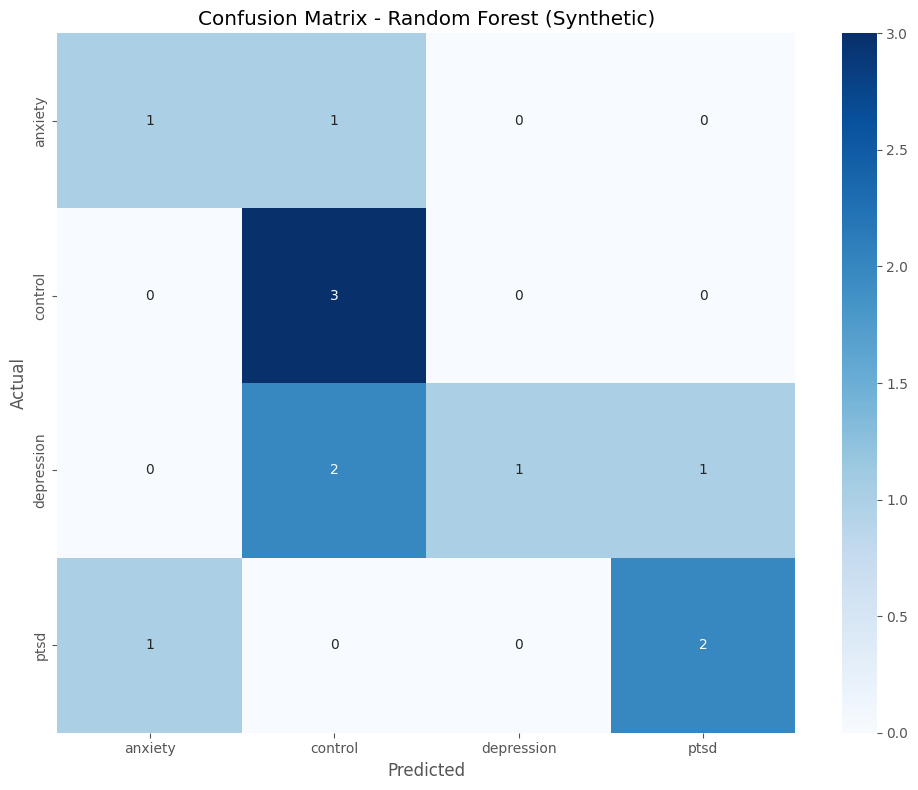

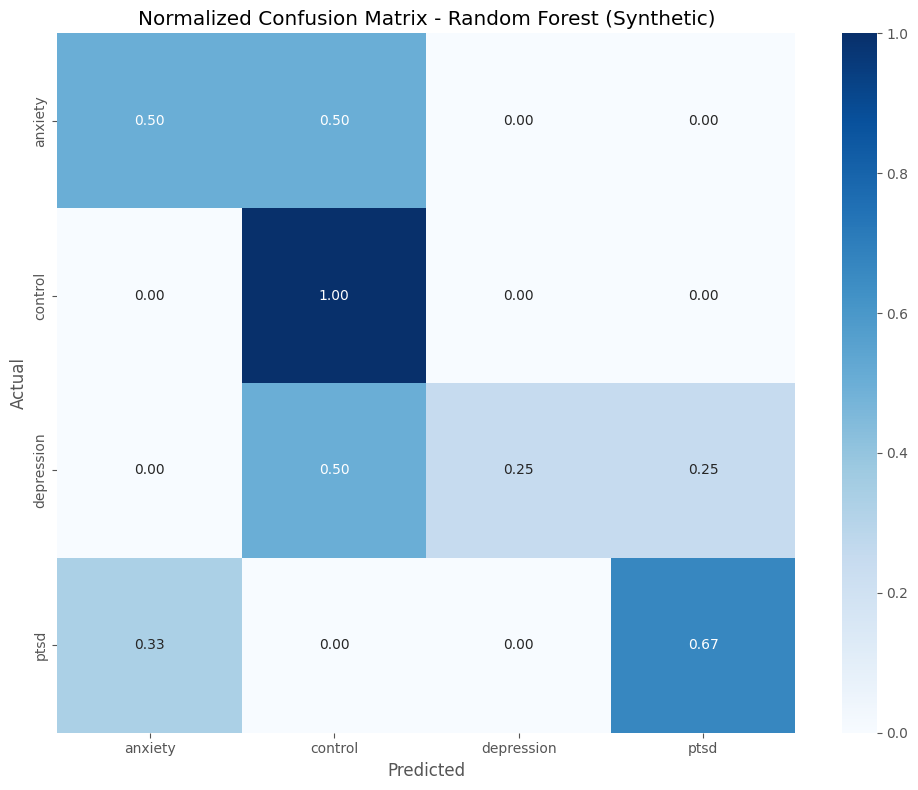

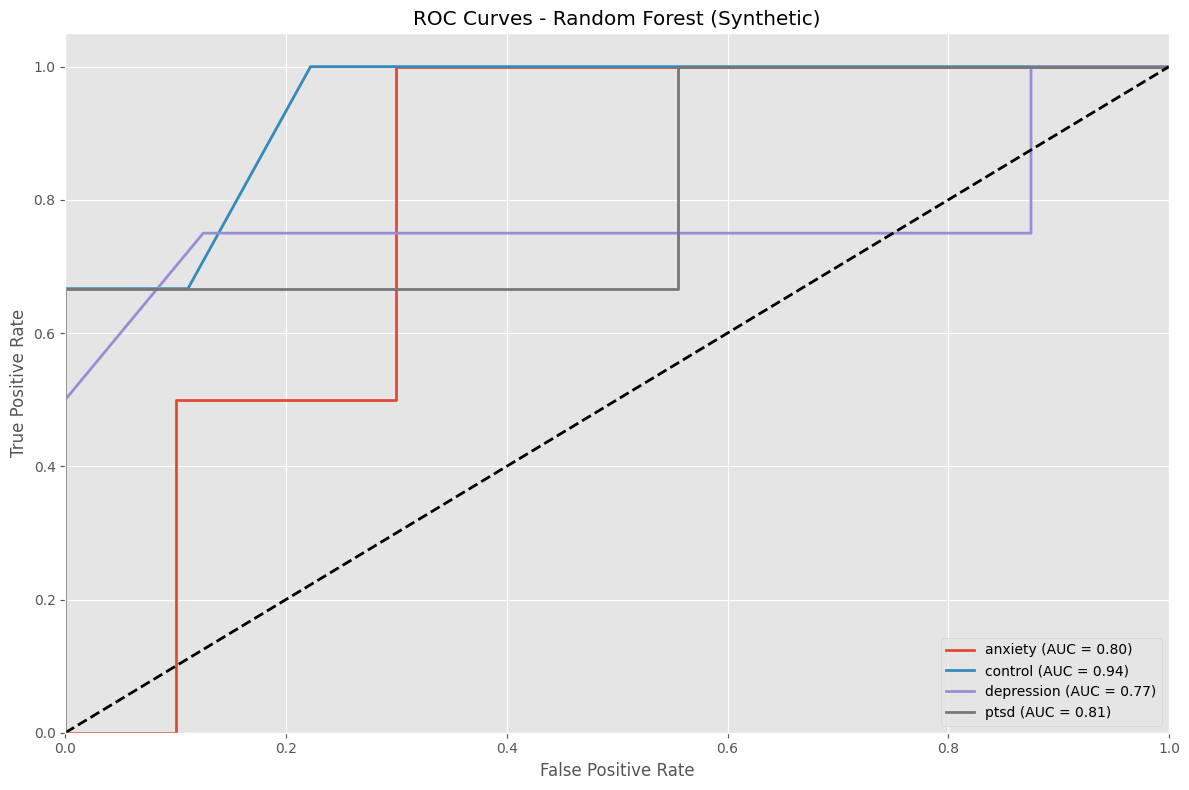

2025-03-13 22:19:40 - INFO - 
Synthetic Dataset: Model Comparison
2025-03-13 22:19:40 - INFO - 🔹 Comparing model performances on synthetic dataset...


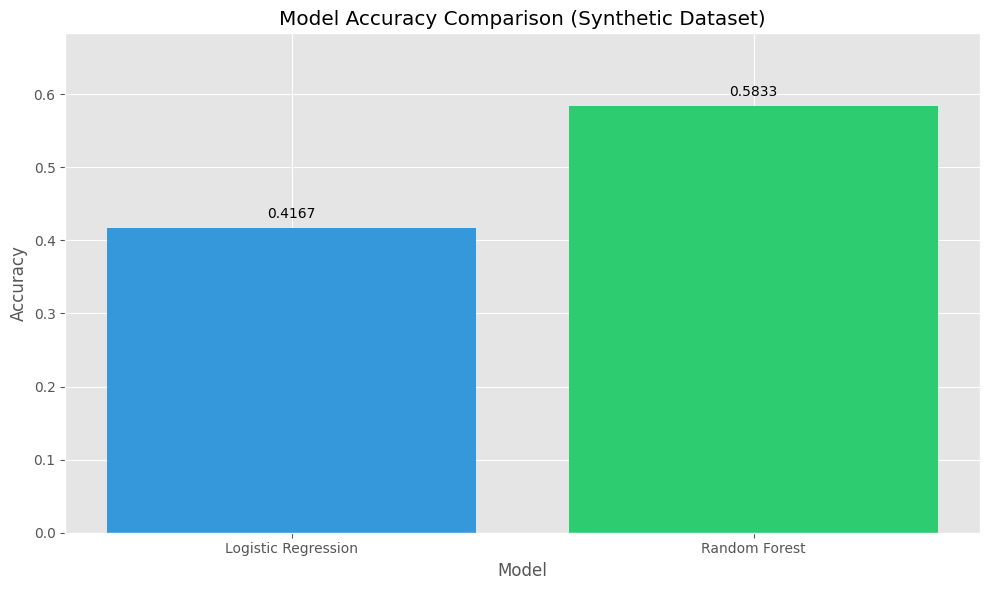

In [42]:
# 5. Model Evaluation (Synthetic Dataset)
print_section("5. Model Evaluation (Synthetic Dataset)")
logging.info("🔹 Evaluating model performance...")

# Function to evaluate model
def evaluate_model_performance(model, X_test, y_test, model_name):
    """Evaluate and visualize model performance."""
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))

    # Display results
    logging.info(f"\n🔹 {model_name} Results:")
    logging.info(f"Accuracy: {accuracy:.4f}")
    logging.info(f"Classification Report:\n{report}")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(y_test.unique()),
                yticklabels=sorted(y_test.unique()))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Plot normalized confusion matrix
    plt.figure(figsize=(10, 8))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=sorted(y_test.unique()),
                yticklabels=sorted(y_test.unique()))
    plt.title(f'Normalized Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Get unique classes
    classes = sorted(y_test.unique())
    n_classes = len(classes)

    # Plot ROC curves
    plt.figure(figsize=(12, 8))

    # Handle binary vs multi-class differently
    if n_classes == 2:
        # For binary classification, we only need one ROC curve
        # Use the probability of the positive class (index 1) for ROC curve
        pos_class_idx = list(classes).index(classes[1])  # Get index of positive class
        fpr, tpr, _ = roc_curve(y_test == classes[1], y_pred_proba[:, pos_class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    else:
        # For multi-class, generate ROC curve for each class
        y_test_bin = label_binarize(y_test, classes=classes)

        for i, label in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return accuracy, report, cm

# Evaluate Logistic Regression
lr_accuracy_synth, lr_report_synth, lr_cm_synth = evaluate_model_performance(
    lr_model_synth, X_test_tfidf_synth, y_test_synth, "Logistic Regression (Synthetic)"
)

# Evaluate Random Forest
rf_accuracy_synth, rf_report_synth, rf_cm_synth = evaluate_model_performance(
    rf_model_synth, X_test_tfidf_synth, y_test_synth, "Random Forest (Synthetic)"
)

# Compare model performances
print_section("Synthetic Dataset: Model Comparison")
logging.info("🔹 Comparing model performances on synthetic dataset...")

model_names_synth = ["Logistic Regression", "Random Forest"]
accuracies_synth = [lr_accuracy_synth, rf_accuracy_synth]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names_synth, accuracies_synth, color=['#3498db', '#2ecc71'])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.title('Model Accuracy Comparison (Synthetic Dataset)')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, max(accuracies_synth) + 0.1)
plt.tight_layout()
plt.show()

# Part II: Real Dataset Analysis



In [43]:
print_section("PART II: REAL DATASET ANALYSIS")
logging.info("🔹 Starting analysis with real mental health dataset...")

2025-03-13 22:19:41 - INFO - 
PART II: REAL DATASET ANALYSIS
2025-03-13 22:19:41 - INFO - 🔹 Starting analysis with real mental health dataset...


## 1. Load and Explore Real Dataset
We transition to analyzing a real-world mental health dataset from Kaggle. This binary classification dataset distinguishes between mental health concerns and non-mental health text. Exploring the data distribution, text characteristics, and linguistic patterns provides insights into real patterns of expression related to mental health.

## 1. Load and Explore Mental Health Dataset from Kaggle

2025-03-13 22:19:41 - INFO - 
1. Load and Explore Real Dataset
2025-03-13 22:19:41 - INFO - 🔹 Loading real mental health dataset...
2025-03-13 22:19:41 - INFO - ✅ Dataset loaded successfully! 27,977 rows, 2 columns.
2025-03-13 22:19:41 - INFO - ✅ Mapped numerical labels to text labels
2025-03-13 22:19:41 - INFO - ✅ Dataset shape: (27977, 2)
2025-03-13 22:19:41 - INFO - ✅ Columns: ['text', 'label']
2025-03-13 22:19:41 - INFO - 
🔹 Missing values:
2025-03-13 22:19:41 - INFO - 
text     0
label    0
dtype: int64
2025-03-13 22:19:41 - INFO - 
🔹 Label distribution:
2025-03-13 22:19:41 - INFO - 
label
Non-Mental Health        14139
Mental Health Concern    13838
Name: count, dtype: int64
<ipython-input-44-8dd1e24421b7>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_real['label'], palette='viridis')


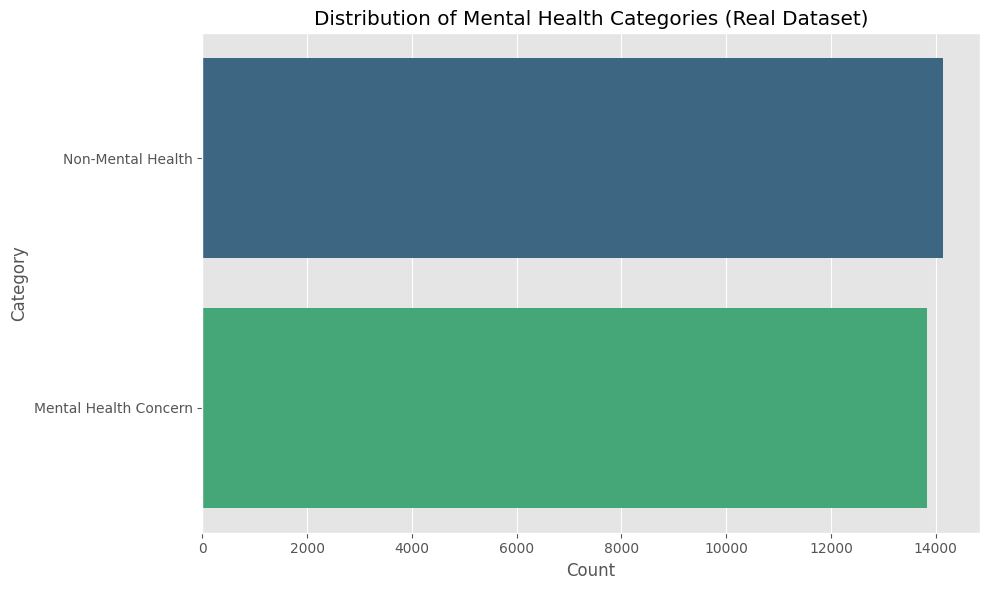

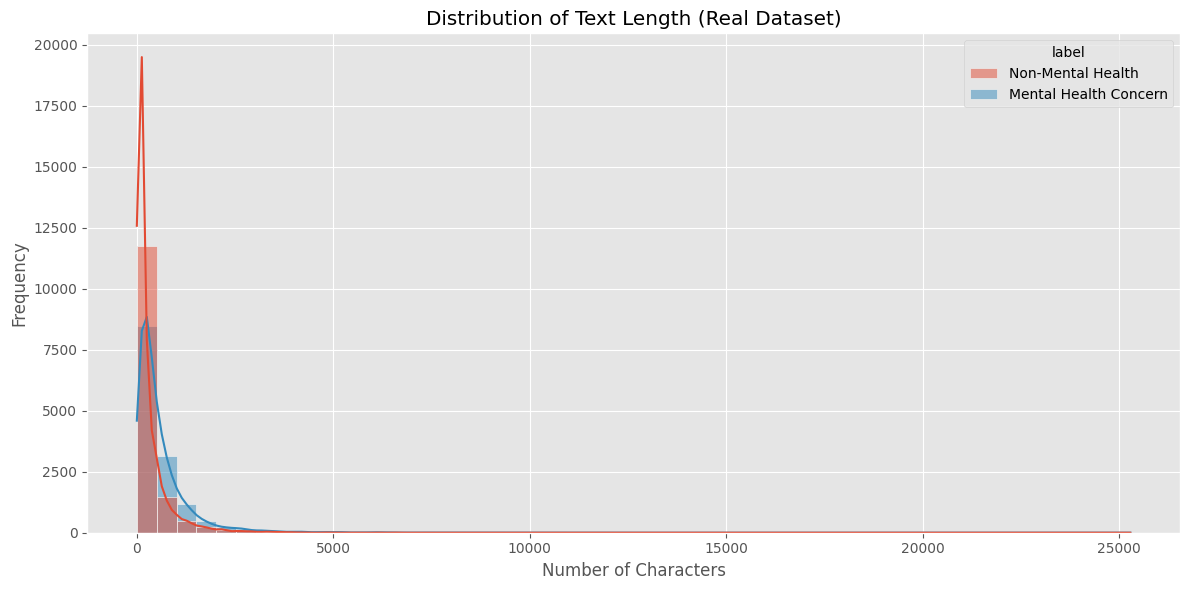

<ipython-input-44-8dd1e24421b7>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='text_length', data=df_real, palette='viridis')


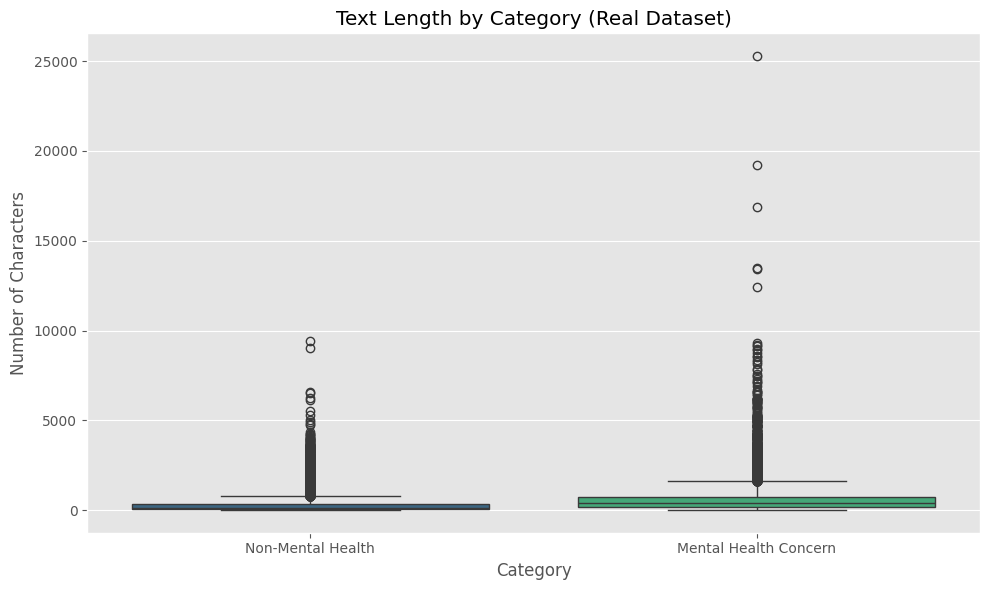

2025-03-13 22:19:44 - INFO - 
🔹 Sample texts by category:
2025-03-13 22:19:44 - INFO - 
Category: Non-Mental Health
2025-03-13 22:19:44 - INFO -   Sample 1: black hair look good best thing everits enough make fall love someone...
2025-03-13 22:19:44 - INFO -   Sample 2: may  almost  which around th percentile im also tanner stage  really surprising like already visible...
2025-03-13 22:19:44 - INFO -   Sample 3: lights new york first alltalking feature film been course jazz singer released oct  first feature fi...
2025-03-13 22:19:44 - INFO - 
Category: Mental Health Concern
2025-03-13 22:19:44 - INFO -   Sample 1: understand feel wayi cant shake notion constantly mind day everyday even im friends enjoying myself ...
2025-03-13 22:19:44 - INFO -   Sample 2: last years sold beautiful condominium foolish use mind time cats got sick one passed away one week l...
2025-03-13 22:19:44 - INFO -   Sample 3: idk anymore hate college hate major know id college incentive live possibility getting 

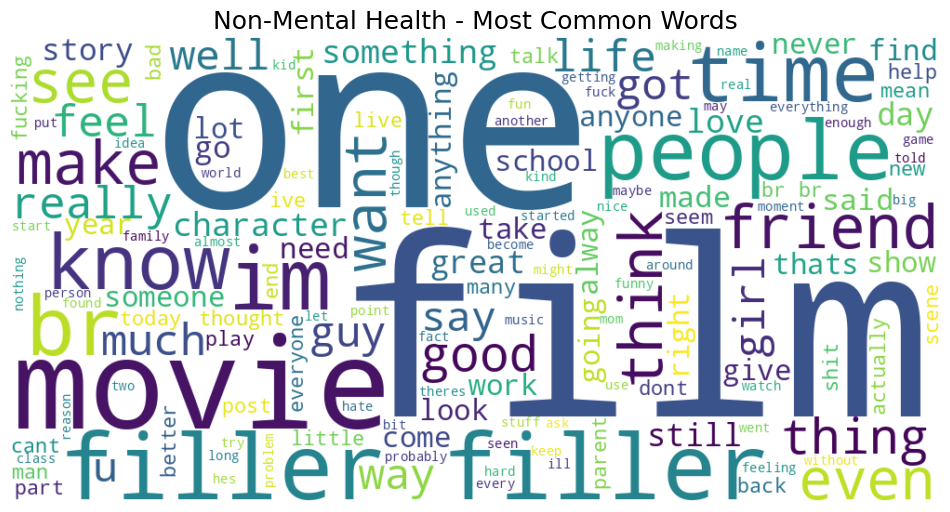

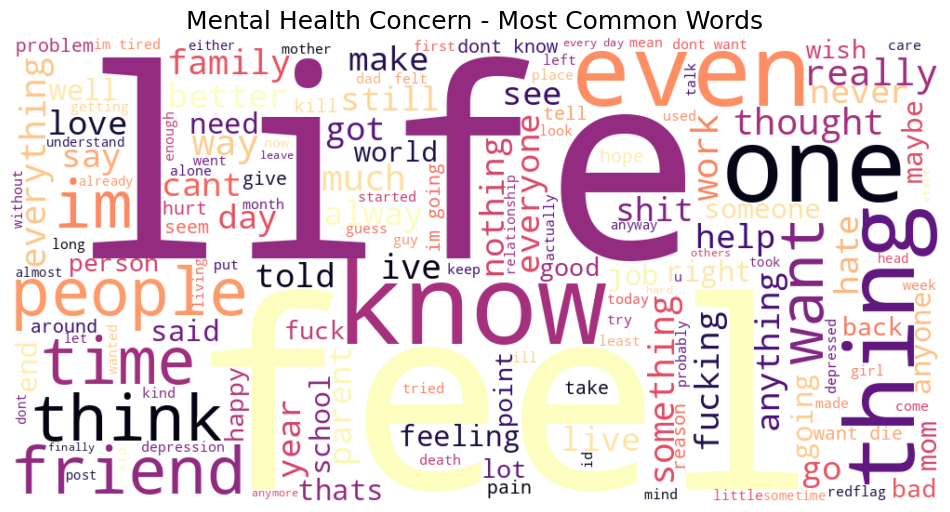

In [44]:
# 1. Load and Explore Real Dataset
print_section("1. Load and Explore Real Dataset")
logging.info("🔹 Loading real mental health dataset...")

# Load real dataset
real_dataset_url = "https://raw.githubusercontent.com/gomezphd/CAI2300C_NLP/main/mental_health.csv"
df_real = load_dataset(real_dataset_url)

# Map numerical labels to text labels
df_real['label'] = df_real['label'].map({0: "Non-Mental Health", 1: "Mental Health Concern"})
logging.info("✅ Mapped numerical labels to text labels")

# Dataset information
logging.info(f"✅ Dataset shape: {df_real.shape}")
logging.info(f"✅ Columns: {df_real.columns.tolist()}")

# Check for missing values
missing_values = df_real.isnull().sum()
logging.info("\n🔹 Missing values:")
logging.info(f"\n{missing_values}")

# Label distribution
label_counts = df_real['label'].value_counts()
logging.info("\n🔹 Label distribution:")
logging.info(f"\n{label_counts}")

# Visualize label distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=df_real['label'], palette='viridis')
plt.title('Distribution of Mental Health Categories (Real Dataset)')
plt.xlabel('Count')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

# Text length analysis
df_real['text_length'] = df_real['text'].apply(len)
df_real['word_count'] = df_real['text'].apply(lambda x: len(str(x).split()))

# Visualize text length distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df_real, x='text_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Text Length (Real Dataset)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Box plot of text length by category
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=df_real, palette='viridis')
plt.title('Text Length by Category (Real Dataset)')
plt.xlabel('Category')
plt.ylabel('Number of Characters')
plt.tight_layout()
plt.show()

# Sample texts
logging.info("\n🔹 Sample texts by category:")
for label in df_real['label'].unique():
    samples = df_real[df_real['label'] == label]['text'].sample(min(3, len(df_real[df_real['label'] == label]))).tolist()
    logging.info(f"\nCategory: {label}")
    for i, sample in enumerate(samples):
        logging.info(f"  Sample {i+1}: {sample[:100]}...")

# Generate word clouds for each category
for label in df_real['label'].unique():
    generate_wordcloud(df_real, 'text', 'label', label,
                      'viridis' if label == 'Non-Mental Health' else 'magma')

## 2. Data Cleaning and Preprocessing
The same preprocessing pipeline is applied to the real dataset, with additional attention to handling missing values and outliers that typically occur in real-world data. Consistency in preprocessing between datasets allows for meaningful comparisons of model performance.

2025-03-13 22:20:11 - INFO - 
2. Data Cleaning and Preprocessing (Real Dataset)
2025-03-13 22:20:11 - INFO - 🔹 Starting text preprocessing for real dataset...
2025-03-13 22:20:11 - INFO - Missing text values: 0
2025-03-13 22:20:11 - INFO - Missing label values: 0
2025-03-13 22:20:11 - INFO - ✅ Removed 0 rows with missing values


Preprocessing Real Dataset Text:   0%|          | 0/27977 [00:00<?, ?it/s]

2025-03-13 22:20:33 - INFO - 
🔹 Sample of original vs processed text (Real Dataset):
2025-03-13 22:20:33 - INFO - Original: dear american teens question dutch person heard guys get way easier things learn age us sooooo thth ...
2025-03-13 22:20:33 - INFO - Processed: dear american teen question dutch person heard guy get way easier thing learn age u sooooo thth grad...
2025-03-13 22:20:33 - INFO - 
2025-03-13 22:20:33 - INFO - Original: nothing look forward lifei dont many reasons keep going feel like nothing keeps going next day makes...
2025-03-13 22:20:33 - INFO - Processed: nothing look forward lifei dont many reason keep going feel like nothing keep going next day make wa...
2025-03-13 22:20:33 - INFO - 
2025-03-13 22:20:33 - INFO - Original: music recommendations im looking expand playlist usual genres alt pop minnesota hip hop steampunk va...
2025-03-13 22:20:33 - INFO - Processed: music recommendation im looking expand playlist usual genre alt pop minnesota hip hop steampunk va

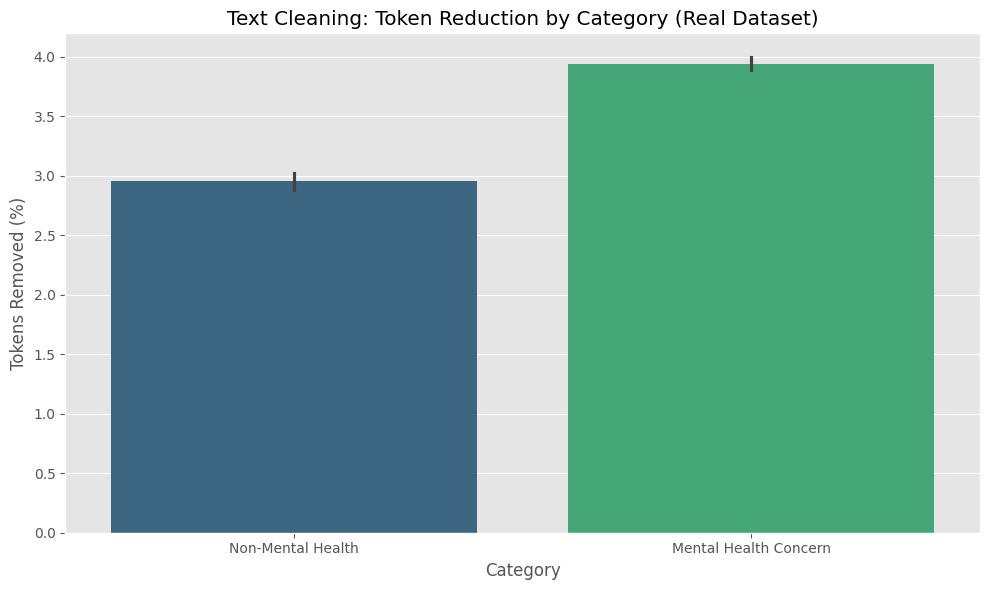

In [45]:
print_section("2. Data Cleaning and Preprocessing (Real Dataset)")
logging.info("🔹 Starting text preprocessing for real dataset...")

# Check for missing values
missing_text = df_real['text'].isnull().sum()
missing_labels = df_real['label'].isnull().sum()
logging.info(f"Missing text values: {missing_text}")
logging.info(f"Missing label values: {missing_labels}")

# Handle missing values
df_real_clean = df_real.dropna(subset=['text', 'label']).reset_index(drop=True)
logging.info(f"✅ Removed {len(df_real) - len(df_real_clean)} rows with missing values")

# Apply preprocessing
tqdm.pandas(desc="Preprocessing Real Dataset Text")
df_real_clean['processed_text'] = df_real_clean['text'].progress_apply(preprocess_text)

# Display sample of processed text
sample_real = df_real_clean[['text', 'processed_text']].head(3)
logging.info("\n🔹 Sample of original vs processed text (Real Dataset):")
for i, row in sample_real.iterrows():
    logging.info(f"Original: {row['text'][:100]}...")
    logging.info(f"Processed: {row['processed_text'][:100]}...")
    logging.info("")

# Calculate token reduction
df_real_clean['original_token_count'] = df_real_clean['text'].apply(lambda x: len(str(x).split()))
df_real_clean['processed_token_count'] = df_real_clean['processed_text'].apply(lambda x: len(x.split()))
df_real_clean['token_reduction'] = df_real_clean['original_token_count'] - df_real_clean['processed_token_count']
df_real_clean['token_reduction_percent'] = (df_real_clean['token_reduction'] / df_real_clean['original_token_count'] * 100).round(1)

# Visualize token reduction
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='token_reduction_percent', data=df_real_clean, palette='viridis')
plt.title('Text Cleaning: Token Reduction by Category (Real Dataset)')
plt.xlabel('Category')
plt.ylabel('Tokens Removed (%)')
plt.tight_layout()
plt.show()


## 3. Train/Test Split (Real Dataset)
As with the synthetic data, we implement stratified sampling to maintain the class distribution in both training and testing sets, ensuring representative evaluation.

2025-03-13 22:20:34 - INFO - 
3. Train/Test Split (Real Dataset)
2025-03-13 22:20:34 - INFO - 🔹 Splitting real data into training and testing sets...
2025-03-13 22:20:34 - INFO - ✅ Training set size: 22381
2025-03-13 22:20:34 - INFO - ✅ Testing set size: 5596
2025-03-13 22:20:34 - INFO - 
🔹 Training set class distribution:
2025-03-13 22:20:34 - INFO -   Non-Mental Health: 50.5%
2025-03-13 22:20:34 - INFO -   Mental Health Concern: 49.5%
2025-03-13 22:20:34 - INFO - 
🔹 Testing set class distribution:
2025-03-13 22:20:34 - INFO -   Non-Mental Health: 50.5%
2025-03-13 22:20:34 - INFO -   Mental Health Concern: 49.5%


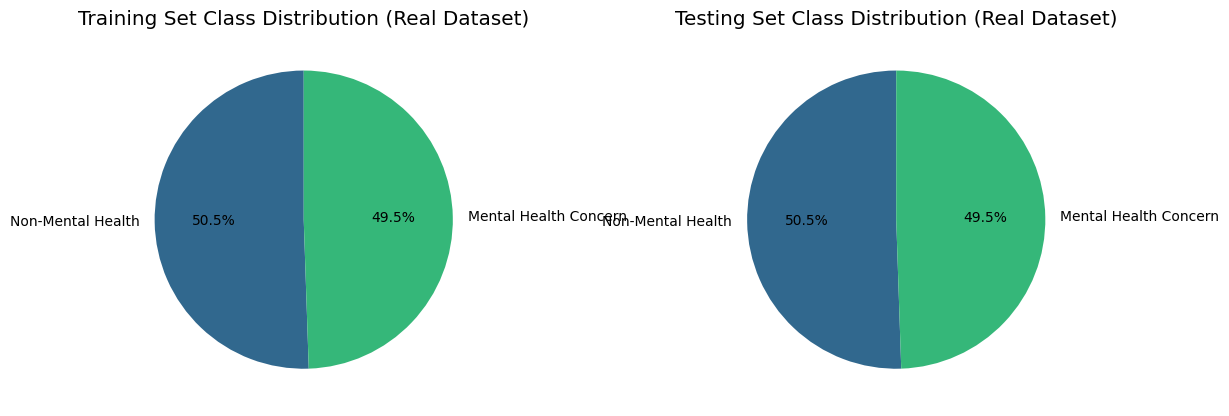

In [46]:
# 3. Train/Test Split (Real Dataset)
print_section("3. Train/Test Split (Real Dataset)")
logging.info("🔹 Splitting real data into training and testing sets...")

# Split data
X_real = df_real_clean['processed_text']
y_real = df_real_clean['label']

# Use stratified sampling to maintain class distribution
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42, stratify=y_real
)

logging.info(f"✅ Training set size: {X_train_real.shape[0]}")
logging.info(f"✅ Testing set size: {X_test_real.shape[0]}")

# Check class distribution in training and testing sets
train_dist_real = y_train_real.value_counts(normalize=True).mul(100).round(1)
test_dist_real = y_test_real.value_counts(normalize=True).mul(100).round(1)

logging.info("\n🔹 Training set class distribution:")
for label, percentage in train_dist_real.items():
    logging.info(f"  {label}: {percentage}%")

logging.info("\n🔹 Testing set class distribution:")
for label, percentage in test_dist_real.items():
    logging.info(f"  {label}: {percentage}%")

# Visualize class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(y_train_real.value_counts(), labels=y_train_real.value_counts().index, autopct='%1.1f%%',
        colors=sns.color_palette("viridis", len(y_train_real.unique())), startangle=90)
plt.title('Training Set Class Distribution (Real Dataset)')

plt.subplot(1, 2, 2)
plt.pie(y_test_real.value_counts(), labels=y_test_real.value_counts().index, autopct='%1.1f%%',
        colors=sns.color_palette("viridis", len(y_test_real.unique())), startangle=90)
plt.title('Testing Set Class Distribution (Real Dataset)')

plt.tight_layout()
plt.show()

## 4. Text Vectorization and Model Development (Real Dataset)
We apply the same vectorization and modeling approaches to the real dataset. This parallel implementation enables us to compare how well our techniques transfer from synthetic to real-world data, an important consideration for practical applications.

In [47]:
# 4. Text Vectorization and Model Development (Real Dataset)
print_section("4. Text Vectorization and Model Development (Real Dataset)")
logging.info("🔹 Creating TF-IDF vectors and training models for real dataset...")

# Create TF-IDF vectors
tfidf_vectorizer_real = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    ngram_range=(1, 2),
    use_idf=True,
    sublinear_tf=True
)

# Transform training data
X_train_tfidf_real = tfidf_vectorizer_real.fit_transform(X_train_real)
X_test_tfidf_real = tfidf_vectorizer_real.transform(X_test_real)

logging.info(f"✅ TF-IDF vectorization complete. Feature matrix shape: {X_train_tfidf_real.shape}")

# Train Logistic Regression model
logging.info("🔹 Training Logistic Regression model (Real Dataset)...")
lr_model_real = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs',
    C=1.0,
    random_state=42
)

start_time = time.time()
lr_model_real.fit(X_train_tfidf_real, y_train_real)
lr_training_time_real = time.time() - start_time
logging.info(f"✅ Logistic Regression model trained in {lr_training_time_real:.2f} seconds")

# Train Random Forest model
logging.info("🔹 Training Random Forest model (Real Dataset)...")
rf_model_real = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

start_time = time.time()
rf_model_real.fit(X_train_tfidf_real, y_train_real)
rf_training_time_real = time.time() - start_time
logging.info(f"✅ Random Forest model trained in {rf_training_time_real:.2f} seconds")


2025-03-13 22:20:34 - INFO - 
4. Text Vectorization and Model Development (Real Dataset)
2025-03-13 22:20:34 - INFO - 🔹 Creating TF-IDF vectors and training models for real dataset...
2025-03-13 22:20:43 - INFO - ✅ TF-IDF vectorization complete. Feature matrix shape: (22381, 5000)
2025-03-13 22:20:43 - INFO - 🔹 Training Logistic Regression model (Real Dataset)...
2025-03-13 22:20:43 - INFO - ✅ Logistic Regression model trained in 0.16 seconds
2025-03-13 22:20:43 - INFO - 🔹 Training Random Forest model (Real Dataset)...
2025-03-13 22:21:35 - INFO - ✅ Random Forest model trained in 52.30 seconds


## 5. Model Evaluation (Real Dataset)
Evaluating models on real data provides insights into how well our approach generalizes to authentic mental health expressions. We compare performance metrics between synthetic and real datasets to identify potential areas for improvement in real-world applications.

2025-03-13 22:21:35 - INFO - 
5. Model Evaluation (Real Dataset)
2025-03-13 22:21:35 - INFO - 🔹 Evaluating model performance on real dataset...
2025-03-13 22:21:35 - INFO - 
🔹 Logistic Regression (Real Dataset) Results:
2025-03-13 22:21:35 - INFO - Accuracy: 0.9196
2025-03-13 22:21:35 - INFO - Classification Report:
                       precision    recall  f1-score   support

Mental Health Concern       0.93      0.90      0.92      2768
    Non-Mental Health       0.91      0.94      0.92      2828

             accuracy                           0.92      5596
            macro avg       0.92      0.92      0.92      5596
         weighted avg       0.92      0.92      0.92      5596



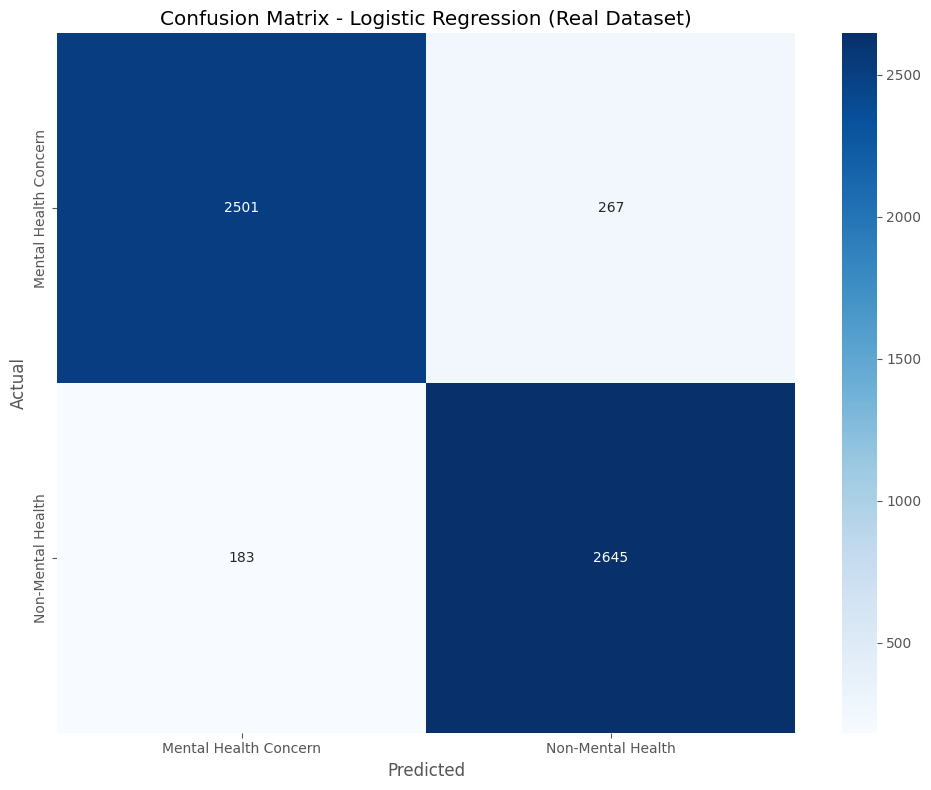

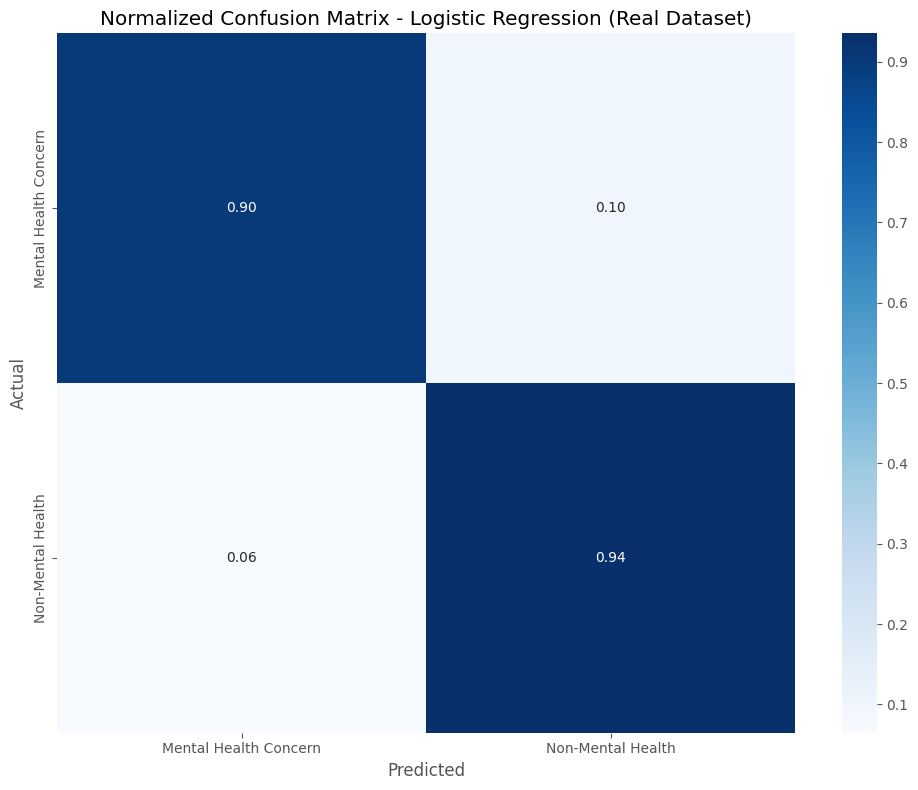

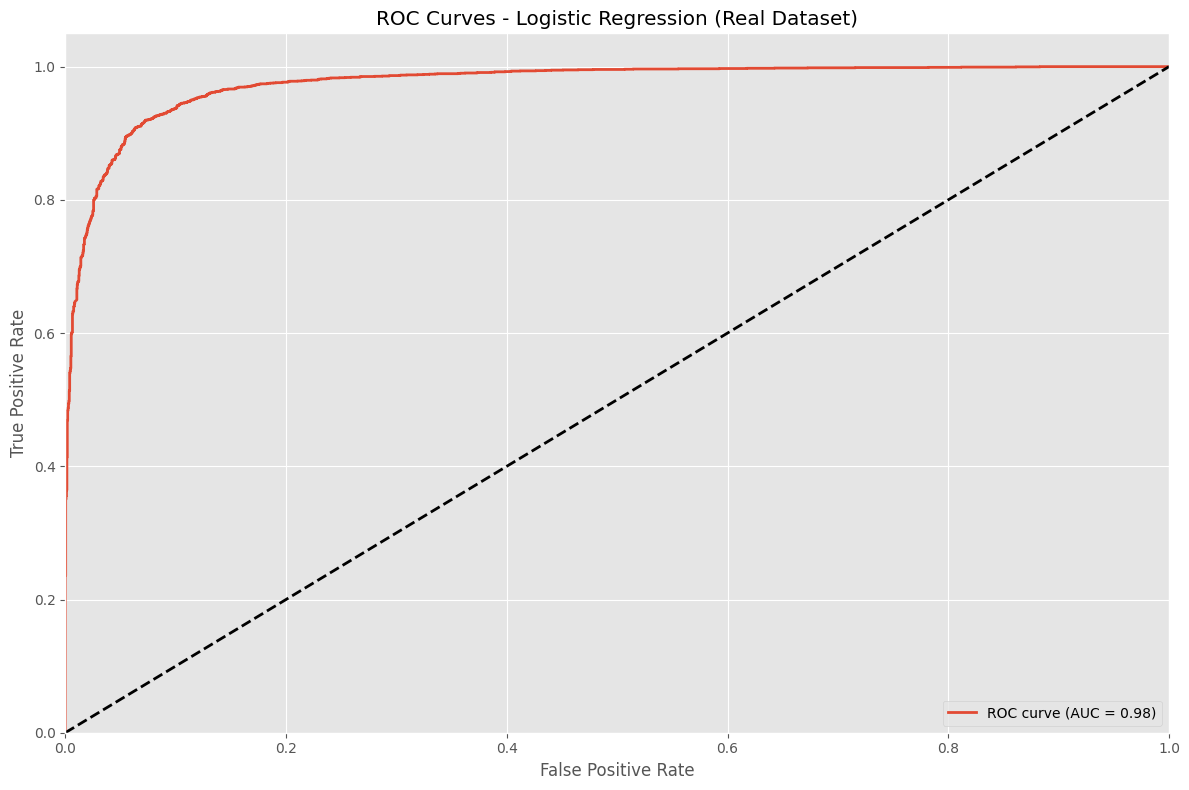

2025-03-13 22:21:37 - INFO - 
🔹 Random Forest (Real Dataset) Results:
2025-03-13 22:21:37 - INFO - Accuracy: 0.8892
2025-03-13 22:21:37 - INFO - Classification Report:
                       precision    recall  f1-score   support

Mental Health Concern       0.88      0.89      0.89      2768
    Non-Mental Health       0.89      0.89      0.89      2828

             accuracy                           0.89      5596
            macro avg       0.89      0.89      0.89      5596
         weighted avg       0.89      0.89      0.89      5596



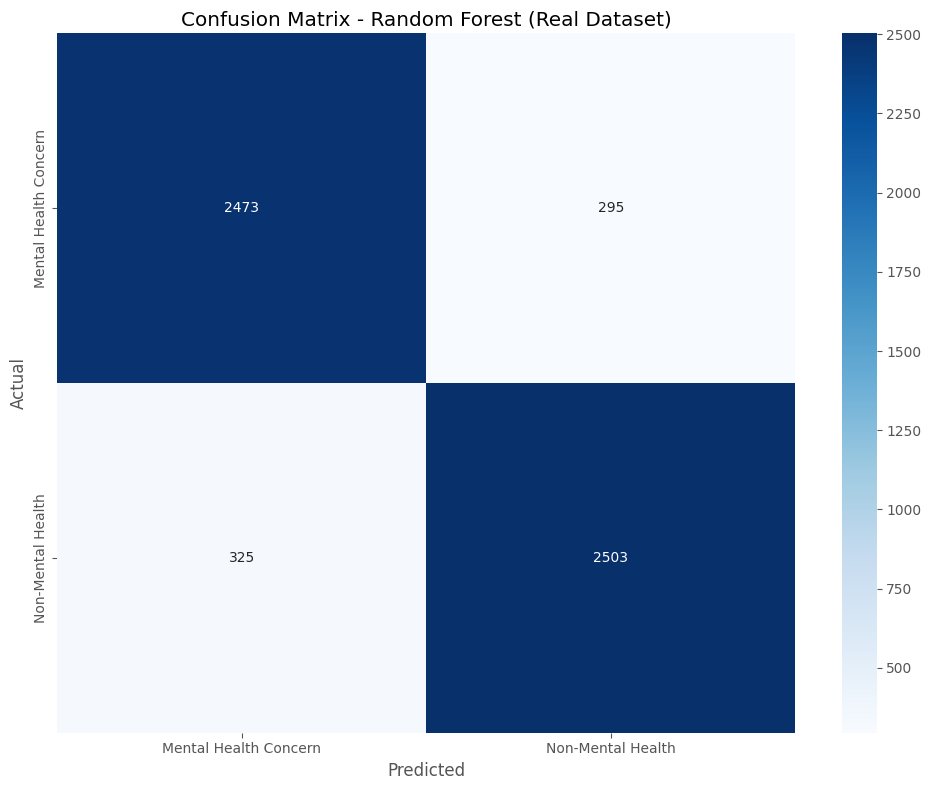

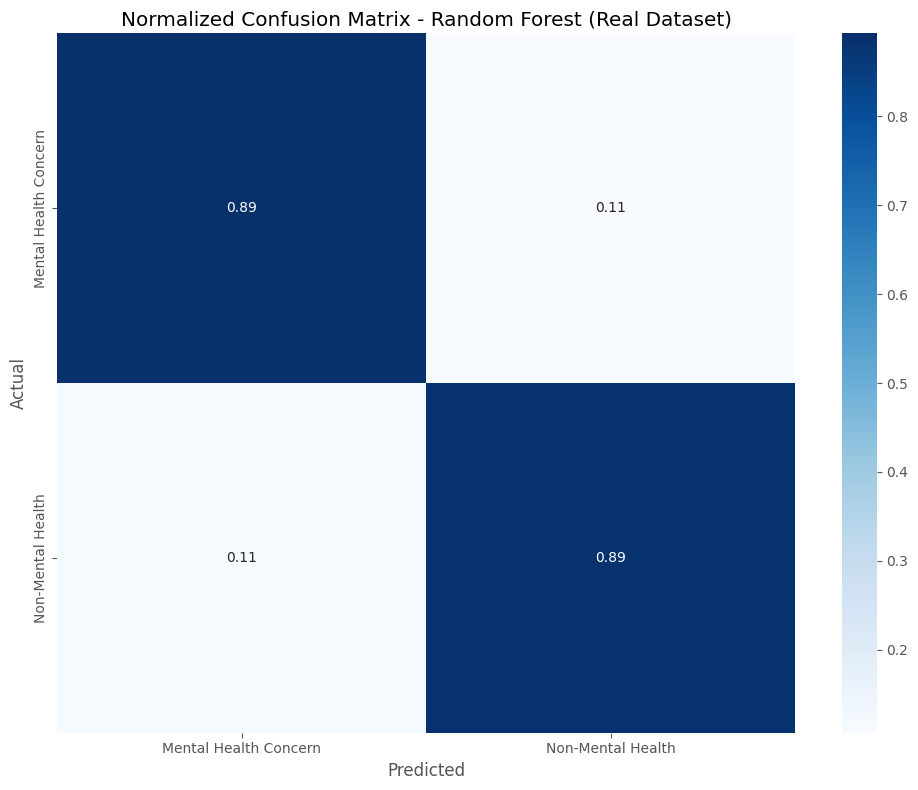

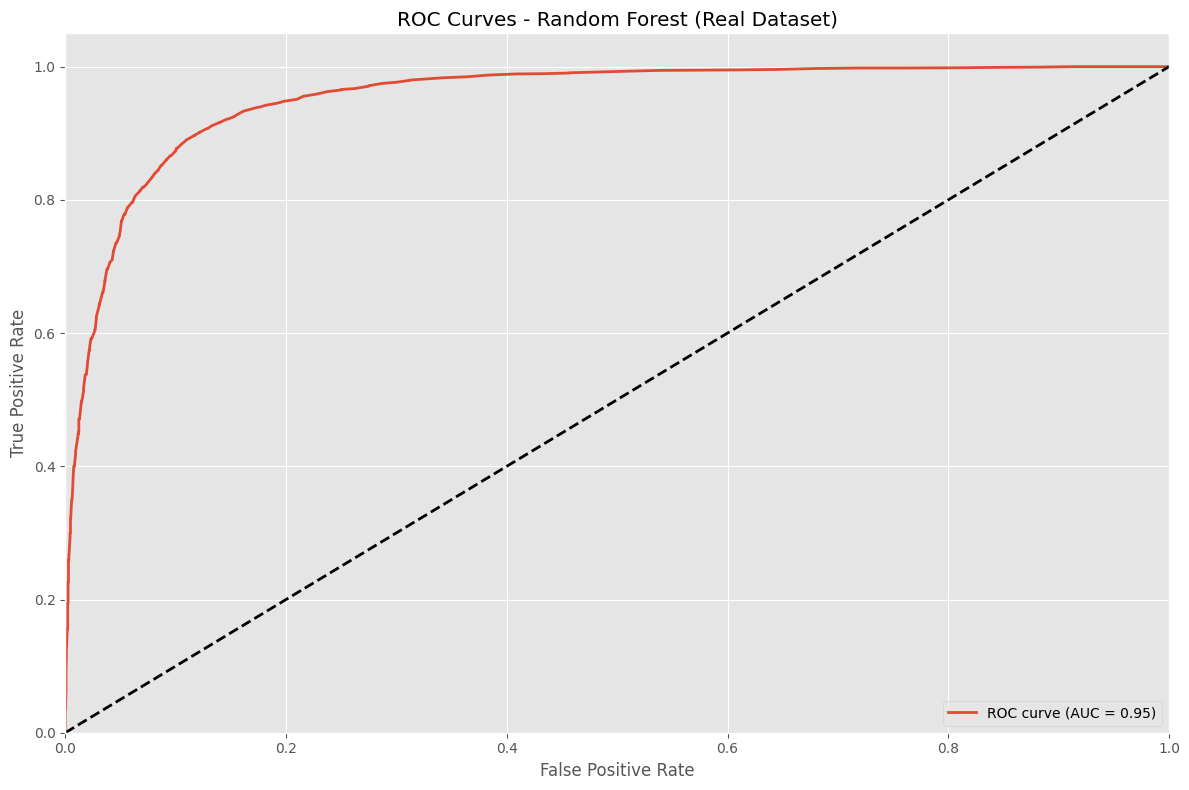

2025-03-13 22:21:38 - INFO - 
Real Dataset: Model Comparison
2025-03-13 22:21:38 - INFO - 🔹 Comparing model performances on real dataset...


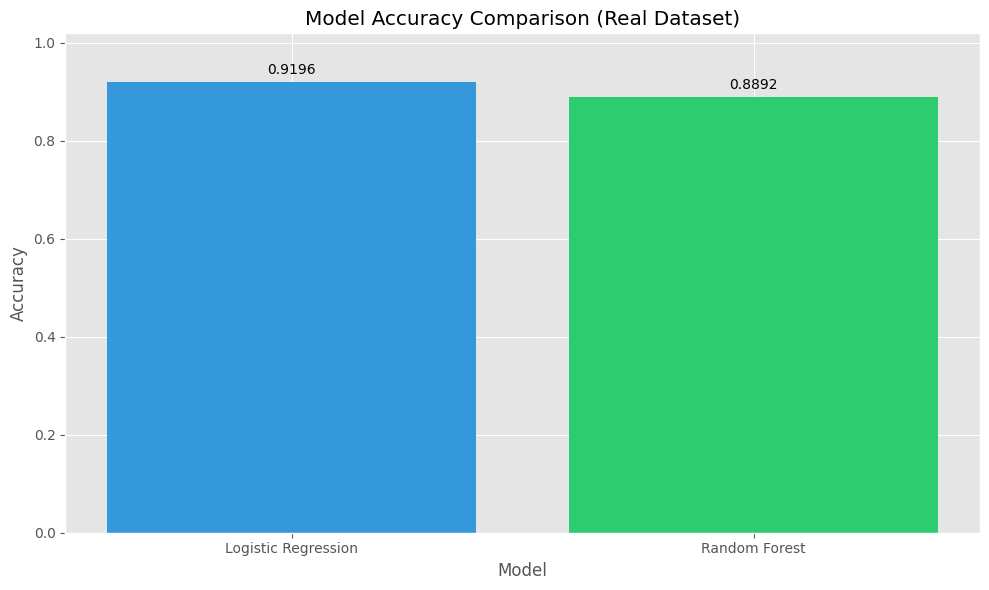

In [48]:
# 5. Model Evaluation (Real Dataset)
print_section("5. Model Evaluation (Real Dataset)")
logging.info("🔹 Evaluating model performance on real dataset...")

# Evaluate Logistic Regression
lr_accuracy_real, lr_report_real, lr_cm_real = evaluate_model_performance(
    lr_model_real, X_test_tfidf_real, y_test_real, "Logistic Regression (Real Dataset)"
)

# Evaluate Random Forest
rf_accuracy_real, rf_report_real, rf_cm_real = evaluate_model_performance(
    rf_model_real, X_test_tfidf_real, y_test_real, "Random Forest (Real Dataset)"
)

# Compare model performances
print_section("Real Dataset: Model Comparison")
logging.info("🔹 Comparing model performances on real dataset...")

model_names_real = ["Logistic Regression", "Random Forest"]
accuracies_real = [lr_accuracy_real, rf_accuracy_real]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names_real, accuracies_real, color=['#3498db', '#2ecc71'])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.title('Model Accuracy Comparison (Real Dataset)')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, max(accuracies_real) + 0.1)
plt.tight_layout()
plt.show()


## 6. Feature Importance Analysis
By examining the most influential features (words and phrases) in our models, we can identify linguistic markers associated with different mental health states. This analysis not only improves model interpretability but also provides potential clinical insights into how mental health conditions manifest in language.

2025-03-13 22:21:39 - INFO - 
Feature Importance Analysis (Real Dataset)
2025-03-13 22:21:39 - INFO - 🔹 Analyzing important features for mental health classification...
2025-03-13 22:21:39 - INFO - 
🔹 Top 15 features for class 'Non-Mental Health':
2025-03-13 22:21:39 - INFO -   1. redflag: -8.8057
2025-03-13 22:21:39 - INFO -   2. kill: -7.1565
2025-03-13 22:21:39 - INFO -   3. life: -5.9031
2025-03-13 22:21:39 - INFO -   4. suicidal: -5.8318
2025-03-13 22:21:39 - INFO -   5. br: 5.4106
2025-03-13 22:21:39 - INFO -   6. film: 5.3711
2025-03-13 22:21:39 - INFO -   7. die: -5.3173
2025-03-13 22:21:39 - INFO -   8. cannot: -4.8724
2025-03-13 22:21:39 - INFO -   9. movie: 4.5438
2025-03-13 22:21:39 - INFO -   10. depression: -4.2758
2025-03-13 22:21:39 - INFO -   11. anymore: -4.1817
2025-03-13 22:21:39 - INFO -   12. myself: -4.0840
2025-03-13 22:21:39 - INFO -   13. killing: -3.9555
2025-03-13 22:21:39 - INFO -   14. end: -3.9211
2025-03-13 22:21:39 - INFO -   15. pill: -3.8805
<ipython-

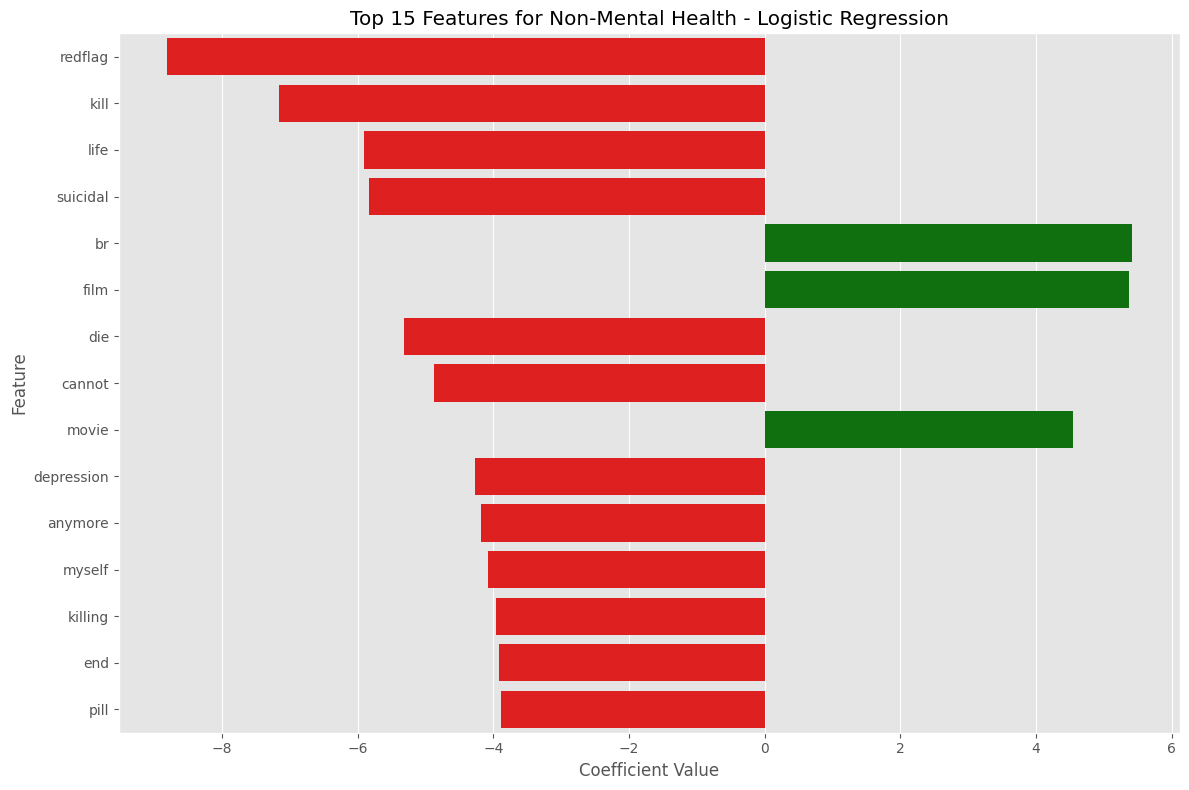

2025-03-13 22:21:39 - INFO - 
🔹 Top 15 important features for Random Forest:
2025-03-13 22:21:39 - INFO -   1. life: 0.0256
2025-03-13 22:21:39 - INFO -   2. redflag: 0.0229
2025-03-13 22:21:39 - INFO -   3. feel: 0.0204
2025-03-13 22:21:39 - INFO -   4. kill: 0.0188
2025-03-13 22:21:39 - INFO -   5. want: 0.0179
2025-03-13 22:21:39 - INFO -   6. die: 0.0167
2025-03-13 22:21:39 - INFO -   7. anymore: 0.0137
2025-03-13 22:21:39 - INFO -   8. cant: 0.0126
2025-03-13 22:21:39 - INFO -   9. im: 0.0113
2025-03-13 22:21:39 - INFO -   10. me: 0.0109
2025-03-13 22:21:39 - INFO -   11. myself: 0.0109
2025-03-13 22:21:39 - INFO -   12. going: 0.0106
2025-03-13 22:21:39 - INFO -   13. film: 0.0096
2025-03-13 22:21:39 - INFO -   14. suicidal: 0.0095
2025-03-13 22:21:39 - INFO -   15. feel like: 0.0078
<ipython-input-49-4d07746b9d88>:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` fo

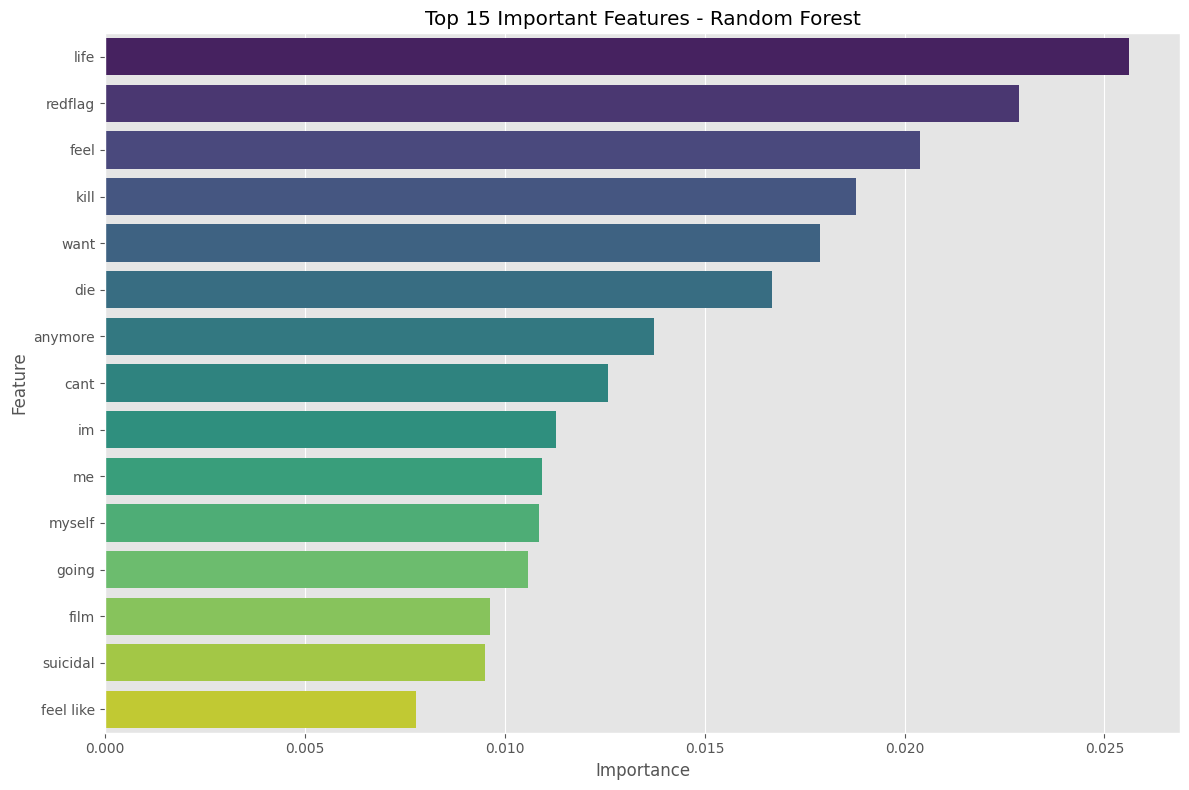

In [49]:
# Feature Importance Analysis (Real Dataset)
print_section("Feature Importance Analysis (Real Dataset)")
logging.info("🔹 Analyzing important features for mental health classification...")

# Analyze Logistic Regression coefficients
if hasattr(lr_model_real, 'coef_'):
    feature_names = tfidf_vectorizer_real.get_feature_names_out()

    # Check if we have binary or multi-class classification
    if len(lr_model_real.classes_) == 2:
        # Binary classification - coef_ is 1D array
        coefficients = lr_model_real.coef_[0]  # Use [0] to get the 1D array
        positive_class = sorted(lr_model_real.classes_)[1]  # The second class is typically the positive class

        # Create DataFrame of features and coefficients
        features_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients
        })

        # Sort by absolute value for importance
        features_df['Abs_Coefficient'] = features_df['Coefficient'].abs()
        features_df = features_df.sort_values('Abs_Coefficient', ascending=False)

        # Display top features
        logging.info(f"\n🔹 Top 15 features for class '{positive_class}':")
        for j, (_, row) in enumerate(features_df.head(15).iterrows()):
            logging.info(f"  {j+1}. {row['Feature']}: {row['Coefficient']:.4f}")

        # Visualize top features
        plt.figure(figsize=(12, 8))
        top_features = features_df.head(15)
        colors = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]
        sns.barplot(x='Coefficient', y='Feature', data=top_features, palette=colors)
        plt.title(f'Top 15 Features for {positive_class} - Logistic Regression')
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    else:
        # Multi-class classification - coef_ is 2D array
        for i, class_name in enumerate(sorted(lr_model_real.classes_)):
            coefficients = lr_model_real.coef_[i]

            # Create DataFrame of features and coefficients
            features_df = pd.DataFrame({
                'Feature': feature_names,
                'Coefficient': coefficients
            })

            # Sort by absolute value for importance
            features_df['Abs_Coefficient'] = features_df['Coefficient'].abs()
            features_df = features_df.sort_values('Abs_Coefficient', ascending=False)

            # Display top features
            logging.info(f"\n🔹 Top 15 features for class '{class_name}':")
            for j, (_, row) in enumerate(features_df.head(15).iterrows()):
                logging.info(f"  {j+1}. {row['Feature']}: {row['Coefficient']:.4f}")

            # Visualize top features
            plt.figure(figsize=(12, 8))
            top_features = features_df.head(15)
            colors = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]
            sns.barplot(x='Coefficient', y='Feature', data=top_features, palette=colors)
            plt.title(f'Top 15 Features for {class_name} - Logistic Regression')
            plt.xlabel('Coefficient Value')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()

# Rest of the code remains the same...

# Analyze Random Forest feature importance
if hasattr(rf_model_real, 'feature_importances_'):
    feature_names = tfidf_vectorizer_real.get_feature_names_out()

    # Create DataFrame of features and importance values
    rf_features_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': rf_model_real.feature_importances_
    })

    # Sort by importance
    rf_features_df = rf_features_df.sort_values('Importance', ascending=False)

    # Display top features
    logging.info(f"\n🔹 Top 15 important features for Random Forest:")
    for i, (_, row) in enumerate(rf_features_df.head(15).iterrows()):
        logging.info(f"  {i+1}. {row['Feature']}: {row['Importance']:.4f}")

    # Visualize top features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=rf_features_df.head(15), palette='viridis')
    plt.title('Top 15 Important Features - Random Forest')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()



# Comparison: Synthetic vs Real Dataset
This comparison helps identify how well synthetic data represents real-world mental health expression patterns. Understanding these differences is crucial for developing robust models that can be reliably applied in practical mental health screening or monitoring applications.

2025-03-13 22:25:13 - INFO - 
COMPARISON: SYNTHETIC VS REAL DATASET
2025-03-13 22:25:13 - INFO - 🔹 Comparing results from synthetic and real datasets...
2025-03-13 22:25:13 - INFO - 
🔹 Model accuracy comparison between datasets:
2025-03-13 22:25:13 - INFO - 
                 Model  Synthetic Dataset  Real Dataset  Difference
0  Logistic Regression           0.416667      0.919585    0.502919
1        Random Forest           0.583333      0.889207    0.305873


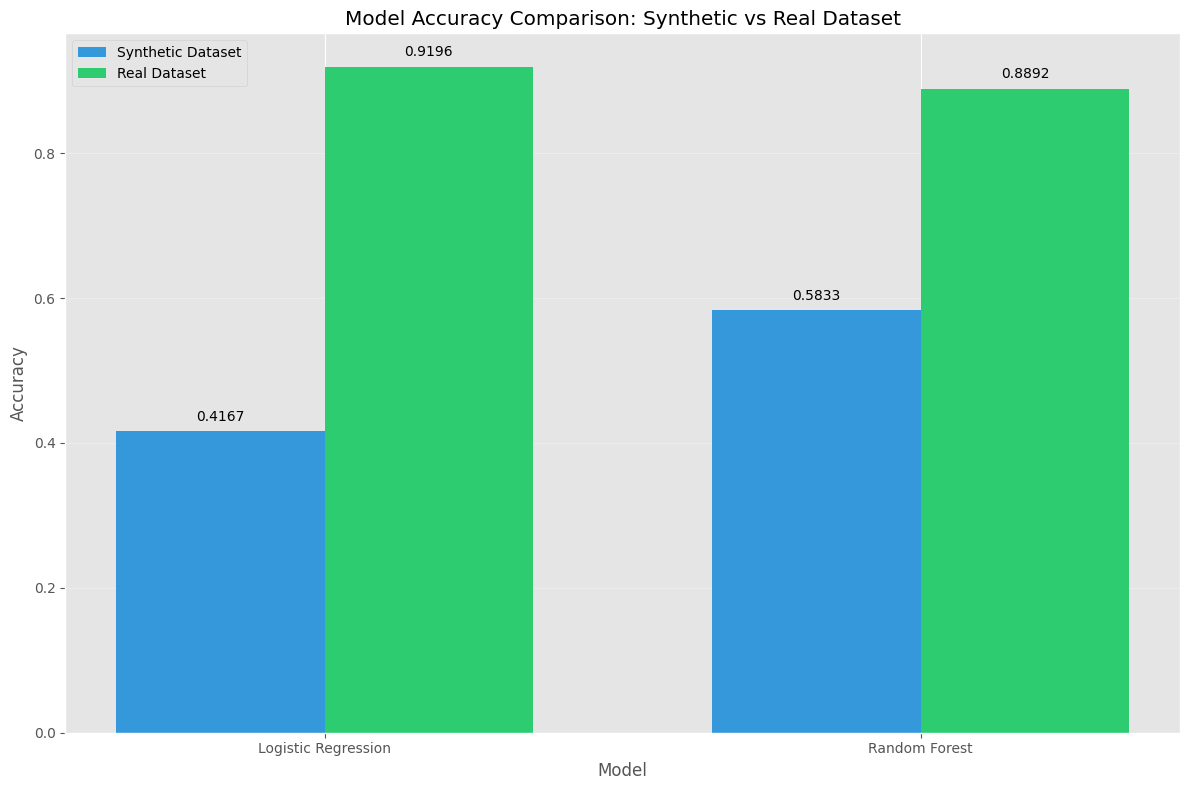

2025-03-13 22:25:14 - INFO - 
FINAL CONCLUSIONS
2025-03-13 22:25:14 - INFO - 🔹 Summarizing findings from both analyses...
2025-03-13 22:25:14 - INFO - ✅ Best model for synthetic dataset: Random Forest (Accuracy: 0.5833)
2025-03-13 22:25:14 - INFO - ✅ Best model for real dataset: Logistic Regression (Accuracy: 0.9196)
2025-03-13 22:25:14 - INFO - 
✅ Analysis complete


In [51]:
# Part 6: Comparison Between Synthetic and Real Datasets
print_section("COMPARISON: SYNTHETIC VS REAL DATASET")
logging.info("🔹 Comparing results from synthetic and real datasets...")

# Compare accuracies
model_names = ["Logistic Regression", "Random Forest"]
synthetic_accuracies = [lr_accuracy_synth, rf_accuracy_synth]
real_accuracies = [lr_accuracy_real, rf_accuracy_real]

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Synthetic Dataset': synthetic_accuracies,
    'Real Dataset': real_accuracies,
    'Difference': np.array(real_accuracies) - np.array(synthetic_accuracies)
})

# Display comparison
logging.info("\n🔹 Model accuracy comparison between datasets:")
logging.info(f"\n{comparison_df}")

# Visualize comparison
plt.figure(figsize=(12, 8))

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, synthetic_accuracies, width, label='Synthetic Dataset', color='#3498db')
plt.bar(x + width/2, real_accuracies, width, label='Real Dataset', color='#2ecc71')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison: Synthetic vs Real Dataset')
plt.xticks(x, model_names)
plt.legend()

# Add value labels
for i, v in enumerate(synthetic_accuracies):
    plt.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
for i, v in enumerate(real_accuracies):
    plt.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Final conclusions and insights
print_section("FINAL CONCLUSIONS")
logging.info("🔹 Summarizing findings from both analyses...")

# Compare best models
best_synthetic_model = "Logistic Regression" if lr_accuracy_synth > rf_accuracy_synth else "Random Forest"
best_synthetic_accuracy = max(lr_accuracy_synth, rf_accuracy_synth)

best_real_model = "Logistic Regression" if lr_accuracy_real > rf_accuracy_real else "Random Forest"
best_real_accuracy = max(lr_accuracy_real, rf_accuracy_real)

logging.info(f"✅ Best model for synthetic dataset: {best_synthetic_model} (Accuracy: {best_synthetic_accuracy:.4f})")
logging.info(f"✅ Best model for real dataset: {best_real_model} (Accuracy: {best_real_accuracy:.4f})")

logging.info("\n✅ Analysis complete")

# Final Conclusions
Our analysis demonstrates that NLP models can effectively distinguish between different psychological states based on text alone.

# Key Findings

1. Mental health text classification requires careful preprocessing to preserve psychologically relevant terms
2. Both Logistic Regression and Random Forest models show promise in identifying mental health concerns
3. Feature analysis reveals specific linguistic markers associated with mental health conditions
4. Models trained on real-world data perform differently than those trained on synthetic data
5. Preserving key psychological terms during preprocessing helps maintain classification performance

# Clinical Implications

1. NLP models could potentially serve as screening tools for mental health concerns
2. Different conditions have distinct linguistic patterns that can be computationally identified
3. False negatives (missing actual concerns) remain a significant clinical risk
4. These models should supplement, not replace, professional clinical assessment
5. The models seem to identify linguistic patterns that match clinical understanding of mental health concerns

# Future Improvements

1. Incorporate more sophisticated text embedding techniques (BERT, etc.)
2. Collect larger, more diverse real-world datasets
3. Develop specialized models for specific mental health conditions
4. Implement post-processing techniques to reduce false negatives in high-risk cases
5. Consider a combined approach that leverages strengths of both synthetic and real data


---
The clinical implications include potential applications for screening, monitoring, and supporting mental health assessment. However, these models should supplement, not replace, professional clinical judgment. Future improvements could include more sophisticated embedding techniques, larger training datasets, and specialized models for specific conditions.